# How and Why BatchNorm Works - Part 2


In Part 1, we showed that batch normalization (BN) can help train neural networks by reducing internal covariate shift (ICS) and smoothing gradient updates. ICS was defined in terms of activation distributions by Ioffe and Szegedy (2015). For our fully-connected network, we indeed observed that the activation distributions for the network with BN were comparatively stable compared to those for the network without BN.
We also touched upon the idea that BN has a smoothing effect on the loss function making it more convex (residual connections have a similar effect).

In their 2018 paper, Santukar et al. used a new definition of ICS and argued that BN has no substantial effect on it. In fact, BN improves training performance even when random noise is added to the activations to force covariate shift.  They argue that the major reason for improved performance loss surface smoothing.

Santurkar et. al define internal covariate shift (ICS) of activation i at time t to be the difference $||Gt,i − G′ t,i||^2$, where
$$
G_{t,i} = ∇W^{(t)}_i L(W (t) 1 , . . . , W (t) k ; x(t), y(t)) G′ t,i = ∇W (t) i L(W (t+1) 1 , . . . , W (t+1) i−1 , W (t) i , W (t) i+1, . . . , W (t) k ; x(t), y(t)).
$$

This is more of an *operational* definition that measures the impact on the gradient of a particular layer due covariate shift. In simple terms, if updating the previous layers changes the activations for the current layer significantly, it should impact the gradient of the current layer significantly as well.


In this experiment, we will start by reproducing the results from Santukar et al. Then we will try and understand why their results and our previous experiment differ.

In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/deepkit
    !cd deepkit && git checkout santurkar-ics && git pull && uv build . --wheel && pip uninstall deepkit -y && pip install ./dist/* --quiet
else:
    import sys
    from pathlib import Path
    package_path = Path("../../deepkit/src").resolve()
    if str(package_path) not in sys.path:
        sys.path.append(str(package_path))




## Let's set up the model
We'll be using the standard VGG-Net architecture as per the paper.






In [2]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx

kernel_init = nnx.initializers.glorot_normal()


class VGGBlock(nnx.Module):
    def __init__(self, in_features: int, out_features: int, rngs: nnx.Rngs):
        self.conv = nnx.Conv(in_features=in_features,
                             out_features=out_features,
                             kernel_size=(3, 3),
                             kernel_init=kernel_init,
                             padding='SAME',
                             rngs=rngs)
        self.bn = nnx.BatchNorm(num_features=out_features, momentum=0.90, rngs=rngs)

    def __call__(self, x):
        x = self.conv(x)
        conv_activation = x
        x = self.bn(x)
        x = nnx.relu(x)
        return x, conv_activation

class VGGNet(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.convs = [
            VGGBlock(in_features=3, out_features=64,  rngs=rngs),
            VGGBlock(in_features=64, out_features=64,  rngs=rngs),

            VGGBlock(in_features=64, out_features=128, rngs=rngs),
            VGGBlock(in_features=128, out_features=128, rngs=rngs),

            VGGBlock(in_features=128, out_features=256, rngs=rngs),
            VGGBlock(in_features=256, out_features=256, rngs=rngs),

            VGGBlock(in_features=256, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),

            VGGBlock(in_features=512, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),
        ]

        self.fc1 = nnx.Linear(in_features=512, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.fc2 = nnx.Linear(in_features=96, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.out = nnx.Linear(in_features=96, out_features=10,  kernel_init=kernel_init, rngs=rngs)

    def __call__(self, x):
        activations = {}
        max_pool_after = [1, 3, 5, 7, 9]
        for conv_idx in range(len(self.convs)):
            layer = self.convs[conv_idx]
            x, act = layer(x)
            activations[f"conv_{conv_idx}"] = act
            if conv_idx in max_pool_after:
                x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.squeeze()

        x = self.fc1(x)
        activations["fc1"] = x
        x = nnx.relu(x)

        x = self.fc2(x)
        activations["fc2"] = x
        x = nnx.relu(x)

        x = self.out(x)
        activations["out"] = x
        return x, activations

In [3]:
rng_key = jax.random.key(42)
rngs = nnx.Rngs(rng_key)
candidate = VGGNet(rngs=rngs)
graphdef, state = nnx.split(candidate)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,476,298 parameters.


In [4]:
rng_key = jax.random.key(42)
rngs = nnx.Rngs(rng_key)
baseline = VGGNet(rngs=rngs)

class Dummy(nnx.Module):
    def __call__(self, x):
        return x

# Remove the batchnorm layers
for vgg in baseline.convs:
  vgg.bn = lambda x: x
graphdef, state = nnx.split(baseline)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,464,522 parameters.


In [5]:
import optax

lr = 0.03
momentum = 0.9


baseline_optimizer = nnx.Optimizer(baseline, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))
candidate_optimizer = nnx.Optimizer(candidate, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))


In [6]:
import copy
from functools import partial


def loss_fn(model, batch, targets):
    logits, activations = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
    return loss, activations

@nnx.jit
def step_fn(model: nnx.Module, optimizer: nnx.Optimizer, batch: jax.Array, labels: jax.Array):
    (loss, activations), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, labels)
    optimizer.update(grads)
    return loss, activations, grads


@nnx.jit
def accuracy(model: nnx.Module, batch: jax.Array, labels: jax.Array):
    logits, _ = model(batch)
    #probs = nnx.softmax(logits, axis=-1)
    preds = jnp.argmax(logits, axis=-1)
    sum = jnp.sum(preds == labels)
    acc = sum/logits.shape[0]
    return acc


def test_accuracy(model: nnx.Module, testloader):
    acc, n = 0, 0
    for batch, labels in testloader:
        batch = jnp.array(batch)
        labels = jnp.array(labels)
        acc += accuracy(model, batch, labels)
        n += 1
    return acc/n



In [7]:
from deepkit.datasets import load_CIFAR10
from deepkit.loggers import DiskLogger


num_epochs = 39

train_loader, test_loader = load_CIFAR10(augment=False)
num_steps = num_epochs*len(train_loader)


# Ioffe et. al Style ICS Measure

In [ ]:
i = 0
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_activations_logger = DiskLogger("baseline_activations")
candidate_activations_logger = DiskLogger("candidate_activations")

: 

In [ ]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

%matplotlib inline

try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)
          baseline.train()
          candidate.train()
          baseline_loss, baseline_activations, baseline_grads = step_fn(baseline, baseline_optimizer, batch, labels)
          candidate_loss, candidate_activations, candidate_grads = step_fn(candidate, candidate_optimizer, batch, labels)
          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)
          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
            baseline_activations_logger.log(i, baseline_activations)
            candidate_activations_logger.log(i, candidate_activations)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | candidate loss: {candidate_loss:0.4f} | baseline train acc: {baseline_acc:0.2f} | candidate train acc: {candidate_acc:0.2f} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9, label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5, label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9, label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5, label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          #print(f"iter: {i} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

Received KeyboardInterrupt. Exiting...


: 

In [ ]:
from matplotlib import colormaps as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

layers = [f"conv_{i}" for i in range(10)] + ["fc1", "fc2", "out"]

fig, axs = plt.subplots(13, 1, figsize=(5,24), constrained_layout=True)


def update(frame):
    baseline_activations = baseline_activations_logger[frame]
    candidate_activations = candidate_activations_logger[frame]
    for layer_idx, layer in enumerate(layers):
        axs[layer_idx].cla()
        layer_baseline_activations = baseline_activations[layer].flatten()
        layer_baseline_mean = layer_baseline_activations.mean()
        layer_baseline_std = layer_baseline_activations.std()
        axs[layer_idx].hist(layer_baseline_activations, color=cm["Blues"](50), bins=60, alpha=1.0)

        layer_candidate_activations = candidate_activations[layer].flatten()
        layer_candidate_mean = layer_candidate_activations.mean()
        layer_candidate_std = layer_candidate_activations.std()
        axs[layer_idx].hist(layer_candidate_activations, color=cm["Reds"](90),  bins=60, alpha=0.5)
        axs[layer_idx].set_title(f"{layer} Outputs - Iteration:{frame}")

        axs[layer_idx].margins(x=0, y=0)
        axs[layer_idx].set_xlim(-8, 8)
        axs[layer_idx].legend([f"Baseline: {layer_baseline_mean:0.2f} ± {layer_baseline_std:0.2f}",
                              f"Candidate:{layer_candidate_mean:0.2f} ± {layer_candidate_std:0.2f}"])


ani = FuncAnimation(fig, update, frames=len(baseline_activations_logger), interval=300, repeat=True)
plt.close(fig)
video_html = ani.to_html5_video().replace('<video', '<video muted')
HTML(video_html)

NameError: name 'plt' is not defined

: 

# Santurkar et. al Implementation of Internal Covariate Shift


In [ ]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_ics_results, candidate_ics_results = [], []
i = 0

iter: 20 | baseline loss: 2.3002 | candidate loss: 1.6817 | baseline train acc: 0.12 | candidate train acc: 0.28 | baseline test acc:  0.10 | candidate test acc:  0.10


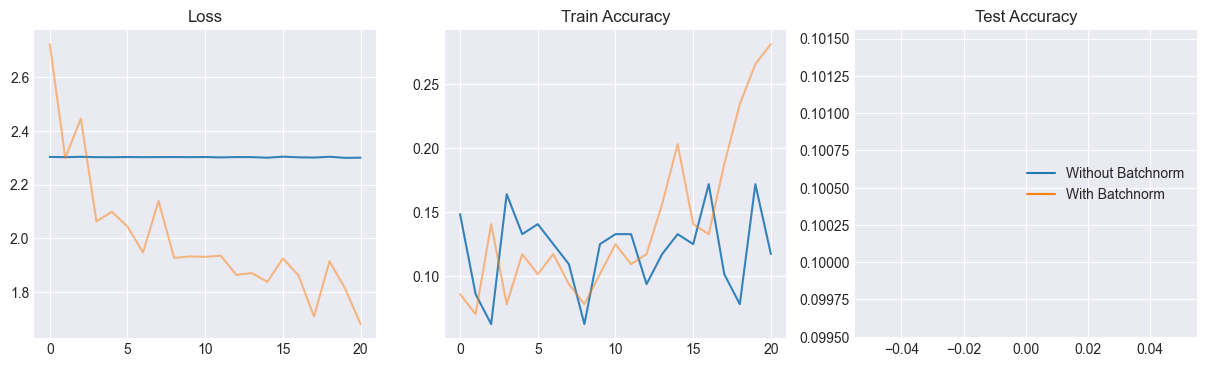

Received KeyboardInterrupt. Exiting...


In [ ]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import santurkar_ics_step

%matplotlib inline


baseline.train()
candidate.train()



try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline_optimizer_copy = baseline_optimizer.__deepcopy__()
          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = step_fn(baseline, baseline_optimizer, batch, labels)
          baseline_optimizer_copy.model.eval()
          baseline_ics_measures = santurkar_ics_step(baseline_optimizer_copy,
                                           baseline_grads,
                                           batch,
                                           labels)
          baseline_ics_results.append(baseline_ics_measures)


          candidate_optimizer_copy = candidate_optimizer.__deepcopy__()
          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = step_fn(candidate, candidate_optimizer, batch, labels)
          candidate_optimizer_copy.model.eval()
          candidate_ics_measures = santurkar_ics_step(candidate_optimizer_copy,
                                           candidate_grads,
                                           batch,
                                           labels)
          candidate_ics_results.append(candidate_ics_measures)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)
          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | candidate loss: {candidate_loss:0.4f} | baseline train acc: {baseline_acc:0.2f} | candidate train acc: {candidate_acc:0.2f} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9, label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5, label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9, label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5, label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          #print(f"iter: {i} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


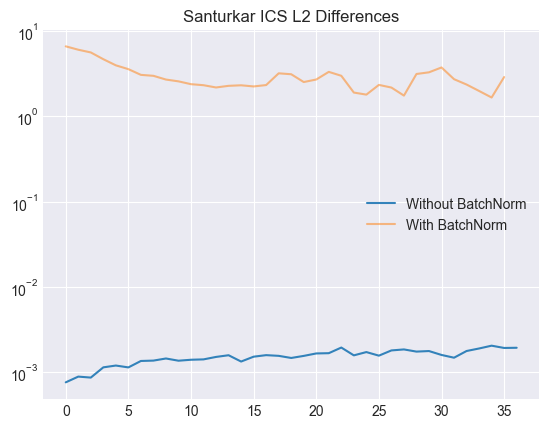

In [ ]:
conv_layer_id = 5

baseline_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value for n in baseline_ics_results ]
candidate_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value for n in candidate_ics_results ]

plt.plot(baseline_kernel_ics_l2_norms, label="Without BatchNorm", alpha=0.9)
plt.plot(candidate_kernel_ics_l2_norms, label="With BatchNorm", alpha=0.5)
plt.yscale('log')
plt.title("Santurkar ICS L2 Differences")
plt.legend()
plt.show()

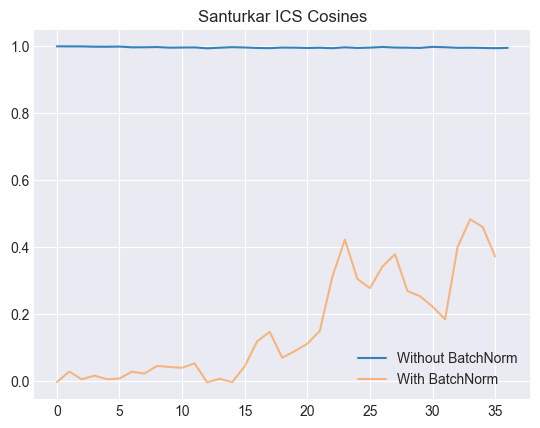

In [ ]:
baseline_kernel_ics_cosines =  [ n[conv_layer_id][1].conv.kernel.value for n in baseline_ics_results ]
candidate_kernel_ics_cosines = [ n[conv_layer_id][1].conv.kernel.value for n in candidate_ics_results ]

plt.plot(baseline_kernel_ics_cosines, label="Without BatchNorm", alpha=0.9)
plt.plot(candidate_kernel_ics_cosines, label="With BatchNorm", alpha=0.5)
plt.title("Santurkar ICS Cosines")
plt.legend()
plt.show()

# Loss Landscape

In [8]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_loss_landscape_ranges, candidate_loss_landscape_ranges = [], []
i = 0

In [9]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import loss_landscape_step

%matplotlib inline


try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = (
               step_fn(baseline, baseline_optimizer, batch, labels)
          )
          baseline_copy = baseline.__deepcopy__()
          baseline_copy.eval()
          baseline_loss_range = (
              loss_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_loss,
                                  baseline_grads,
                                  max_step=40,
                                  step_size=1,
                                  lr=lr
             )
          )
          baseline_loss_landscape_ranges.append(baseline_loss_range)

          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = (
              step_fn(candidate, candidate_optimizer, batch, labels)
          )
          candidate_copy = candidate.__deepcopy__()
          candidate_copy.eval()
          candidate_loss_range = (
            loss_landscape_step(candidate,
                                batch,
                                labels,
                                candidate_loss,
                                candidate_grads,
                                max_step=40,
                                step_size=1,
                                lr=lr
             )
          )
          candidate_loss_landscape_ranges.append(candidate_loss_range)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)

          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | "
                  f"candidate loss: {candidate_loss:0.4f} | "
                  f"baseline train acc: {baseline_acc:0.2f} | "
                  f"candidate train acc: {candidate_acc:0.2f} | "
                  f"baseline test acc: {baseline_test_acc: 0.2f} | "
                  f"candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9,
                         label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5,
                         label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9,
                         label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5,
                         label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'flax.nnx.statelib.State'>, [38;2;79;201;177mState[0m[38;2;255;213;3m({[0m[38;2;105;105;105m[0m
  [38;2;156;220;254m'convs'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
    [38;2;156;220;254m0[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 64 (256 B)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-6.99306256e-05,  2.58226442e-04, -2.20830028e-04, -1.00304882e-04,
                  1.32751142e-04,  6.39355130e-06, -1.08409542e-04,  2.34746462e-04,
                 -2.02351439e-05, -1.05974534e-04,  8.57994310e-05, -1.95011977e-04,
                 -2.82422334e-05,  1.98247799e-05, -6.81202437e-05, -1.55456713e-04,
                 -1.36498915e-04,  2.40624504e-05,  1.58284383e-04,  1.95380126e-04,
                 -1.74348650e-04, -1.12083289e-04,  6.72246169e-05,  4.14898619e-04,
                  6.76017662e-05,  1.72604749e-04,  1.17969394e-05, -2.23486466e-04,
                  1.17932461e-04,  2.05345990e-04,  3.67619941e-05,  1.62124954e-04,
                 -1.13269934e-05, -2.08557358e-05,  3.87298351e-04,  2.57146719e-04,
                  1.10865309e-04,  1.47345447e-04, -3.04010027e-05,  6.68107969e-05,
                  2.59561668e-04, -2.90992321e-05, -1.26471117e-04, -2.05969161e-04,
                  1.50998807e-04,  1.80993709e-04, -1.16572090e-04,  2.11948282e-06,
                  8.06742100e-05, -1.27584499e-04,  1.93066255e-04,  1.02943552e-04,
                  2.24693085e-05, -5.62090463e-05, -2.24577070e-05,  2.62854446e-04,
                  1.11059257e-04, -2.06797573e-04, -2.68953299e-04,  1.14522816e-04,
                 -2.79876440e-05,  1.55891277e-04,  1.96673398e-04,  3.13821147e-05],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 1,728 (6.9 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-1.70654239e-04,  1.72015629e-04, -2.09040751e-04, ...,
                    -1.49646949e-04,  3.86598113e-05, -1.97249246e-04],
                   [-1.83073033e-04,  1.88470716e-04, -3.72513401e-04, ...,
                    -2.18557660e-04,  1.19159358e-06, -2.34703650e-04],
                   [-1.19815581e-04,  2.74355873e-04, -4.87494224e-04, ...,
                    -1.80466246e-04, -4.96452230e-05, -2.22512987e-04]],
          
                  [[-9.63147759e-05,  1.82505042e-04, -1.63172575e-04, ...,
                    -9.95435767e-05, -6.90031957e-05, -1.71644278e-04],
                   [-9.79706310e-05,  1.99968956e-04, -3.43514781e-04, ...,
                    -1.64176192e-04, -9.66581065e-05, -2.04873082e-04],
                   [-4.38943571e-05,  2.50402372e-04, -4.76984365e-04, ...,
                    -1.36524337e-04, -1.43261626e-04, -1.82540054e-04]],
          
                  [[-1.29840380e-04,  1.52565102e-04, -1.63285513e-04, ...,
                    -4.80344461e-05, -7.88762845e-05, -1.72408865e-04],
                   [-1.00130099e-04,  1.73305481e-04, -3.49419046e-04, ...,
                    -1.02389022e-04, -1.19237491e-04, -2.07989418e-04],
                   [-2.46869931e-05,  2.14997635e-04, -4.70655155e-04, ...,
                    -9.09446389e-05, -1.68205210e-04, -1.56918410e-04]]],
          
          
                 [[[-9.98176401e-05,  1.78859584e-04, -2.24819873e-04, ...,
                    -2.77159008e-04, -6.71357411e-05, -1.33610039e-04],
                   [-8.22868460e-05,  1.48276013e-04, -4.01392288e-04, ...,
                    -2.73566635e-04, -1.10170615e-04, -1.75371228e-04],
                   [-4.79050068e-05,  2.35591593e-04, -5.39730710e-04, ...,
                    -2.26685064e-04, -1.67286460e-04, -1.56266848e-04]],
          
                  [[-7.56398804e-05,  1.79714392e-04, -1.73781664e-04, ...,
                    -2.15216874e-04, -5.78488871e-05, -1.49054918e-04],
                   [-5.51735575e-05,  1.69350824e-04, -3.54786345e-04, ...,
                    -2.36134423e-04, -7.91010898e-05, -1.85774537e-04],
                   [-2.05460819e-05,  2.16623055e-04, -4.94973268e-04, ...,
                    -2.10348022e-04, -1.56806942e-04, -1.50655542e-04]],
          
                  [[-9.05046618e-05,  1.54362569e-04, -1.50241278e-04, ...,
                    -8.71015654e-05, -6.79959630e-05, -1.58355804e-04],
                   [-4.33416426e-05,  1.49468862e-04, -3.18423787e-04, ...,
                    -1.10374385e-04, -9.18067672e-05, -1.91899235e-04],
                   [ 7.94457083e-06,  1.83846772e-04, -4.45650541e-04, ...,
                    -1.18250478e-04, -1.67714432e-04, -1.31197390e-04]]],
          
          
                 [[[-4.94199739e-05,  1.53849935e-04, -1.37625713e-04, ...,
                    -2.62516027e-04, -1.52390334e-04, -7.34733549e-05],
                   [-5.54608414e-06,  7.96580280e-05, -3.07511218e-04, ...,
                    -2.21128867e-04, -1.79709023e-04, -1.01892831e-04],
                   [ 2.02905630e-05,  1.67985883e-04, -4.54059802e-04, ...,
                    -1.69722844e-04, -2.49512435e-04, -8.40480425e-05]],
          
                  [[-7.63027347e-05,  1.84531120e-04, -1.37217168e-04, ...,
                    -2.31661936e-04, -9.20970197e-05, -9.01921303e-05],
                   [-4.16284529e-05,  1.32361267e-04, -3.04997433e-04, ...,
                    -2.20887305e-04, -1.14444985e-04, -1.19473269e-04],
                   [-1.56496953e-05,  2.01289804e-04, -4.39381489e-04, ...,
                    -1.95413450e-04, -2.11282444e-04, -8.81388623e-05]],
          
                  [[-6.56768389e-05,  1.82053831e-04, -1.50283769e-04, ...,
                    -9.28058216e-05, -5.41636837e-05, -1.37296840e-04],
                   [-1.21875819e-05,  1.41653290e-04, -2.93292396e-04, ...,
                    -8.15128515e-05, -8.13948645e-05, -1.70064770e-04],
                   [ 1.57120758e-06,  1.99649367e-04, -4.19535761e-04, ...,
                    -9.66481748e-05, -1.72831598e-04, -1.08809254e-04]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m1[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 64 (256 B)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-1.36887145e-04,  1.84753895e-04,  7.43049459e-05,  3.00112151e-06,
                  5.45096176e-04, -1.63642806e-04, -3.30033188e-04, -1.30293018e-04,
                 -2.57073611e-04, -9.87259991e-05, -1.26648520e-04, -6.83663602e-05,
                 -7.11937173e-06,  7.39338575e-05,  5.43547503e-06, -2.63694150e-04,
                 -1.91308456e-04,  1.52456050e-04,  1.40479824e-06,  7.88623292e-05,
                  2.05754463e-04,  1.12157992e-04,  1.61954638e-04, -1.20116907e-04,
                 -3.08174422e-05, -2.08523779e-04, -9.06210480e-05,  1.39163487e-04,
                  1.45639482e-04,  1.33492693e-04, -1.37857482e-04,  2.94551392e-05,
                  5.42241978e-05,  3.48016038e-04, -3.66966924e-05,  5.85033704e-05,
                 -6.38964339e-05, -3.34516080e-05,  2.38717243e-04,  6.05693567e-05,
                  1.68813509e-04,  2.48480064e-04,  4.02262231e-04, -2.30855570e-04,
                  1.09812383e-04,  4.02068370e-04, -7.62717027e-05,  3.54713178e-04,
                 -1.02248370e-04, -2.90639466e-04, -1.23561302e-04,  1.08738743e-04,
                  5.34528735e-05, -5.28950623e-05, -1.38106770e-04, -5.56571176e-05,
                 -9.49797250e-05, -1.06912375e-04,  5.99302148e-05,  2.47767661e-04,
                 -1.13386406e-04, -8.73629469e-05, -6.80352750e-05,  1.93333108e-04],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 36,864 (147.5 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-1.27951546e-06, -6.58050922e-05, -1.49382658e-05, ...,
                    -2.60852667e-05, -3.61015700e-05, -1.56527622e-05],
                   [ 7.25347718e-06,  4.05551400e-05,  2.75825332e-05, ...,
                    -2.43072282e-05, -1.28596348e-05, -1.34611128e-05],
                   [-3.57971985e-05, -1.56141577e-05,  1.26411369e-05, ...,
                    -9.65345862e-07, -2.30968890e-05,  1.07380320e-05],
                   ...,
                   [-3.25534311e-05,  2.88100691e-05,  5.03867886e-06, ...,
                    -1.87195401e-05,  2.52139289e-05,  1.02176811e-04],
                   [-4.91995997e-05,  2.41565558e-05,  2.61456098e-05, ...,
                    -1.51388840e-05,  5.19759124e-06,  1.35388373e-05],
                   [-5.52565725e-05,  2.19929316e-05, -3.80902056e-05, ...,
                    -1.76400808e-05, -3.20310864e-05, -5.38959102e-06]],
          
                  [[-1.91929594e-05, -4.46449885e-05, -8.47289630e-06, ...,
                    -3.40885017e-05, -3.52244497e-05, -1.85176814e-05],
                   [ 3.51040908e-05, -2.69501015e-05,  1.57138129e-05, ...,
                    -1.18468188e-05,  7.58690419e-07, -2.92992700e-05],
                   [-4.63916804e-05,  1.94129607e-05,  1.17185455e-05, ...,
                    -7.39712095e-06, -2.22620238e-05,  2.23754182e-06],
                   ...,
                   [-1.54155096e-05,  4.02036239e-05,  2.27011915e-05, ...,
                    -5.49051083e-06,  2.71273984e-05,  1.20746117e-04],
                   [-4.62083190e-05, -1.04998580e-05,  7.65736877e-06, ...,
                    -1.17843674e-05,  6.73381010e-06,  3.09559073e-05],
                   [-1.83589291e-05, -1.46434616e-06, -2.69145153e-06, ...,
                    -2.05126707e-05, -7.16790146e-06, -1.30047110e-05]],
          
                  [[-5.40824249e-06, -6.05057794e-05,  9.03879481e-06, ...,
                    -7.40581963e-05, -2.15641976e-05, -3.24012435e-05],
                   [-4.41073553e-06, -5.96849850e-06,  1.33641670e-05, ...,
                    -3.25961410e-05, -2.72555917e-06, -2.85103270e-05],
                   [-2.67293781e-05, -1.31390916e-05,  1.67073140e-05, ...,
                    -1.45415679e-05,  9.70081373e-07, -2.20377819e-06],
                   ...,
                   [-3.48472240e-05,  5.23049639e-05,  2.01176717e-05, ...,
                     2.64580171e-06,  1.96978744e-05,  9.87333187e-05],
                   [-3.85120729e-05,  2.20205311e-05,  2.30258938e-05, ...,
                    -1.81016603e-05,  1.05044965e-05,  3.53434152e-05],
                   [-1.77674156e-05, -7.45106263e-06, -7.05404364e-06, ...,
                    -1.72999153e-05, -2.27708369e-06, -2.00399536e-05]]],
          
          
                 [[[-8.73694735e-05, -4.77802605e-05, -5.63645290e-06, ...,
                    -1.22018773e-05, -4.33698842e-05, -2.58451964e-05],
                   [-2.29161269e-05,  1.26598155e-04,  1.29620039e-05, ...,
                    -2.70994815e-06, -8.51116329e-06,  5.79150810e-06],
                   [-3.74800220e-05,  2.75192997e-06,  9.31352770e-06, ...,
                     4.86892213e-06, -2.50164776e-05,  1.06306979e-05],
                   ...,
                   [-3.28912356e-05,  2.18302994e-05,  2.37627455e-06, ...,
                    -3.32790041e-05,  4.43833196e-05,  9.49039240e-05],
                   [-2.48080378e-05,  4.37121198e-05,  1.18167518e-05, ...,
                    -1.08930353e-05,  1.24694507e-05,  6.25143803e-05],
                   [-6.13193697e-05,  6.56256161e-05, -1.47230194e-05, ...,
                    -2.26435972e-07, -2.33416049e-05,  2.58953150e-05]],
          
                  [[-6.75185365e-05, -2.27145611e-05, -1.49610532e-05, ...,
                    -2.77812178e-05, -4.13929847e-05, -2.43389095e-05],
                   [ 2.86088707e-05,  2.94590282e-05,  1.93102314e-05, ...,
                    -1.05131812e-05,  9.78673143e-06, -2.42719907e-05],
                   [-5.11502039e-05,  2.86648956e-05,  1.70599997e-05, ...,
                     1.18509593e-06, -1.50614796e-05,  1.33675221e-05],
                   ...,
                   [-4.11059737e-05,  3.57274948e-05,  1.91481631e-05, ...,
                    -2.12275172e-05,  2.98700179e-05,  1.20628698e-04],
                   [-3.94804956e-05,  3.67155881e-05,  1.43092132e-06, ...,
                    -7.69417693e-06,  1.43152383e-05,  4.39018622e-05],
                   [-2.14414704e-05,  4.15566647e-05, -2.69548991e-06, ...,
                     5.96349855e-06, -3.25360725e-06,  1.27645199e-05]],
          
                  [[-3.60440499e-05, -2.62864232e-05,  2.38390166e-05, ...,
                    -5.94108715e-05, -1.12752778e-05, -2.46739510e-05],
                   [ 1.05823881e-06,  2.63603797e-05,  1.40238744e-05, ...,
                    -8.94415734e-06,  5.59177761e-06, -1.81137875e-05],
                   [-3.18217972e-05,  2.27488472e-05,  9.46970158e-06, ...,
                     1.46733089e-06,  6.61109516e-06,  6.49397589e-06],
                   ...,
                   [-3.61225830e-05,  3.97599215e-05,  2.30238147e-05, ...,
                    -1.39864469e-05,  2.11762035e-05,  8.87390415e-05],
                   [-5.96774189e-05,  5.06555771e-05,  7.83432188e-06, ...,
                    -9.72812131e-07,  1.45988815e-05,  6.16097386e-05],
                   [-1.80296975e-05,  1.91748895e-05, -5.01193972e-06, ...,
                     1.06107009e-05,  2.40755412e-06, -1.14932597e-07]]],
          
          
                 [[[-1.31742534e-04,  2.77299750e-06,  6.15082263e-06, ...,
                     8.17734872e-06, -3.33586468e-05, -3.88805165e-06],
                   [-2.45344054e-05,  1.39396594e-04, -2.44941702e-07, ...,
                    -2.00039472e-06, -1.17499712e-05,  4.80373565e-05],
                   [-4.25908729e-05, -1.33748995e-06,  1.72111450e-05, ...,
                    -7.45765476e-07, -2.09839218e-05,  4.65637549e-06],
                   ...,
                   [-3.71897768e-05,  1.98812842e-08,  1.97913414e-05, ...,
                    -2.15015971e-05,  3.39558464e-05,  8.90545343e-05],
                   [-1.67663220e-05,  1.68794668e-05,  1.69478826e-05, ...,
                    -2.53402359e-05,  9.20657567e-06,  3.13853270e-05],
                   [-6.20106512e-05,  7.62874115e-05, -1.43165335e-05, ...,
                     5.11623784e-06, -3.84702253e-06,  2.97672032e-05]],
          
                  [[-1.04485938e-04,  3.21354455e-05, -1.86547459e-05, ...,
                     8.59709303e-07, -2.16950502e-05, -5.20695767e-06],
                   [ 2.76948913e-06,  7.62476193e-05, -2.65640438e-06, ...,
                    -3.21588209e-06, -3.09478946e-06,  8.97159953e-06],
                   [-4.89150079e-05,  1.84646615e-05,  1.69077503e-05, ...,
                     4.55101556e-08, -3.19960782e-06,  2.02598530e-05],
                   ...,
                   [-3.33745484e-05,  1.59997398e-05,  2.61401947e-05, ...,
                    -1.21065777e-05,  1.82060576e-05,  9.46682703e-05],
                   [-6.38606207e-06,  8.22263064e-06,  1.42805754e-06, ...,
                    -1.34705560e-05,  3.02829903e-06,  1.06370671e-05],
                   [-3.34035794e-05,  5.94081903e-05,  8.98823055e-06, ...,
                     5.79472953e-06, -4.84503744e-08,  1.00049292e-05]],
          
                  [[-5.55214683e-05,  1.74691577e-05,  2.44796229e-05, ...,
                    -2.91757988e-05,  8.60483397e-06, -4.80203880e-06],
                   [-5.16563034e-07,  3.39407816e-05, -1.91012386e-05, ...,
                     1.34397187e-05,  6.86323756e-06,  4.83688041e-07],
                   [-3.85303247e-05,  2.70888158e-05,  1.87103888e-05, ...,
                     2.17754018e-06,  3.58248030e-06,  1.19972938e-05],
                   ...,
                   [-4.91152823e-05,  1.45755548e-05,  2.82767796e-05, ...,
                    -1.55149773e-05,  1.54267982e-05,  6.24568638e-05],
                   [-1.47070914e-05,  1.75245950e-05,  6.79606637e-06, ...,
                     1.30382532e-05,  7.53202539e-06,  1.90661649e-05],
                   [-2.80013937e-05,  4.32295892e-05, -4.77640742e-06, ...,
                     8.86272392e-06,  1.39638487e-07, -8.86037742e-06]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m2[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 128 (512 B)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-4.72052561e-05, -1.90402468e-04, -2.78688531e-05,  3.69048474e-04,
                 -9.55422001e-05,  2.26165954e-04,  1.42706864e-04,  3.27376547e-05,
                 -7.56530499e-05, -3.98077373e-06,  3.04835557e-04,  1.32101937e-04,
                  5.89859883e-05, -5.59706939e-04, -4.86522971e-04,  8.60795808e-06,
                 -5.53224003e-04, -5.54759114e-04, -7.08729567e-05,  9.46456712e-05,
                  3.62051651e-08,  2.79565662e-04,  7.82965290e-05,  2.09192222e-04,
                  5.76354942e-05, -2.56267987e-04,  1.52661160e-05,  1.32902991e-04,
                 -1.52422217e-07, -1.09255561e-05, -5.38221539e-05,  2.48103548e-04,
                 -6.17209065e-04,  4.77486537e-05, -3.20066210e-05,  3.26557347e-05,
                  5.46024530e-05, -1.47124883e-05, -6.46258268e-05, -1.10544177e-04,
                 -7.74329965e-05, -1.40896969e-04,  8.12525468e-05,  1.33430018e-04,
                  2.87218194e-04, -1.39925498e-04,  1.19941345e-04,  2.48668221e-04,
                  1.27350097e-04,  3.65441549e-04,  2.45046394e-04,  1.39877920e-05,
                 -1.01719197e-04,  7.84276926e-06, -8.34996172e-07,  8.62390007e-05,
                  5.82471221e-05, -1.01776059e-05,  6.38344864e-05,  3.04678513e-04,
                 -4.07269399e-05, -3.13464261e-06, -1.73826076e-04,  1.02256163e-04,
                 -1.57645642e-04,  2.22143335e-05, -1.02437727e-04,  1.51252578e-04,
                 -1.60581985e-04,  1.41149794e-05, -9.55188516e-05,  6.68940775e-05,
                  2.67602125e-04,  1.27516687e-04, -3.07709815e-05, -5.86917740e-05,
                 -1.83308948e-04, -2.50452576e-05,  1.07102707e-04,  6.25739704e-05,
                 -9.04996486e-05, -3.51580638e-05,  3.03775523e-05,  2.20335831e-04,
                  9.90255794e-05, -2.21251375e-05,  6.72888491e-05, -8.89448438e-06,
                 -5.33957136e-05,  4.03363374e-05,  2.48820841e-04, -1.18873155e-04,
                 -2.41735164e-04,  2.25712793e-05, -7.80191767e-05,  1.61126853e-04,
                  1.09681287e-05, -5.81755012e-05,  1.29204884e-04,  1.56301481e-04,
                 -1.55608170e-04, -1.51053930e-04,  2.62668880e-04, -1.78204020e-04,
                 -1.82655975e-04, -3.44795262e-04, -4.53309040e-05,  1.25120423e-04,
                  1.66934769e-04,  7.05600723e-06,  1.49792177e-04,  6.84011320e-06,
                  9.66487278e-05,  9.27308211e-05, -2.00123686e-05, -4.14454495e-04,
                 -1.09379529e-04,  6.84768078e-04,  3.22358275e-04, -5.53261125e-05,
                 -1.87872647e-04,  3.94830626e-04,  1.42642355e-04,  2.81677960e-04,
                  2.62117304e-04,  4.29145410e-04,  2.36895212e-05,  3.13719356e-05],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 73,728 (294.9 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-6.27120062e-06, -8.55482649e-05,  2.58271084e-05, ...,
                     1.33810754e-04, -2.73892638e-05,  1.40725588e-05],
                   [ 4.69266752e-06, -2.32783859e-05,  5.95554457e-06, ...,
                     2.80422701e-05, -1.46793755e-05,  1.04201699e-05],
                   [-5.15008560e-06, -5.74122350e-05,  3.29552095e-05, ...,
                     2.13869371e-05, -2.28313747e-05,  9.70856399e-06],
                   ...,
                   [-3.23442214e-06, -1.44988662e-05,  5.33620823e-06, ...,
                    -6.51401797e-06,  1.00184434e-05,  3.34007518e-06],
                   [ 6.40641338e-06, -1.38989280e-05, -8.32280057e-06, ...,
                     1.09735868e-06,  1.81430187e-05, -3.49161223e-06],
                   [ 1.10109158e-05, -1.06186744e-05, -2.17355919e-05, ...,
                     8.07725737e-05, -4.09872746e-06, -1.93993742e-06]],
          
                  [[-4.99404769e-06, -9.17280195e-05,  3.59138248e-05, ...,
                     1.33602953e-04, -2.30077239e-05,  2.15595210e-05],
                   [-6.44201054e-06, -1.17227337e-05,  1.30073158e-05, ...,
                     2.71290901e-05, -3.81997670e-05,  1.92502248e-05],
                   [ 1.92613379e-06, -6.87790889e-05,  3.46114211e-05, ...,
                     2.64050450e-05, -7.48884268e-05,  2.61863988e-05],
                   ...,
                   [-3.95758389e-06, -2.22722520e-05, -2.83958366e-06, ...,
                    -2.81722305e-06,  1.68173883e-05, -8.98301550e-06],
                   [ 5.95428219e-06, -1.60830004e-05,  1.40346992e-06, ...,
                     3.26924237e-06,  7.97332814e-06,  3.40850079e-06],
                   [ 2.35677544e-06, -1.88613797e-07, -1.76516805e-05, ...,
                     7.96523454e-05, -1.33722851e-05, -3.63084314e-06]],
          
                  [[ 6.67186612e-07, -9.61360493e-05,  5.32358245e-05, ...,
                     1.38844145e-04, -2.56017811e-05,  2.98729319e-05],
                   [-7.21265133e-06, -3.64871303e-05, -2.41145040e-06, ...,
                     4.30257678e-05, -4.70915293e-05,  1.77845868e-05],
                   [ 1.01737089e-06, -6.49714420e-05,  2.18376135e-05, ...,
                     4.72624997e-05, -5.81420791e-05,  4.58489958e-05],
                   ...,
                   [ 1.39485326e-06, -2.01038911e-05, -1.34261950e-06, ...,
                    -5.78683910e-07, -1.27018575e-06, -3.85955900e-06],
                   [ 9.02719785e-06, -1.29352829e-05, -2.67425617e-06, ...,
                     2.23593906e-06,  1.92688294e-05,  2.11925135e-06],
                   [ 7.44873319e-08, -7.38482413e-06, -1.34213606e-05, ...,
                     7.70265251e-05,  7.33179877e-06, -5.96004020e-06]]],
          
          
                 [[[-3.61977595e-06, -5.82847970e-05,  1.33938565e-05, ...,
                     1.45192796e-04, -4.09817985e-05,  2.31964405e-05],
                   [-7.35051344e-07, -6.15130148e-06, -4.14082797e-06, ...,
                     3.13230194e-05, -2.13205221e-05,  1.53969195e-05],
                   [-3.67616030e-06, -2.24549985e-05,  6.33133232e-06, ...,
                     2.36988308e-05, -7.53128043e-05,  1.42492072e-05],
                   ...,
                   [ 3.51120235e-07, -1.35103473e-05,  1.89327420e-06, ...,
                     9.01161820e-06,  1.54520985e-05, -1.58134253e-06],
                   [ 5.47719355e-06, -2.17879915e-05,  5.73209900e-06, ...,
                     6.24260838e-06,  1.94396416e-05, -1.97690747e-06],
                   [ 3.36849052e-06, -1.89529474e-05, -8.76271497e-06, ...,
                     8.54695027e-05, -1.98914549e-05,  1.69947962e-05]],
          
                  [[-9.98281052e-07, -5.68735923e-05,  8.75172645e-06, ...,
                     1.45186277e-04, -5.91268727e-05,  1.41943683e-05],
                   [-4.32647948e-06,  5.48364642e-06,  7.81351355e-06, ...,
                     3.66103777e-05, -4.11121327e-05,  9.24587403e-06],
                   [-9.46302316e-06, -2.47287353e-05,  2.21941918e-05, ...,
                     6.51786977e-05, -8.79724248e-05,  1.31412062e-05],
                   ...,
                   [ 1.91323647e-06, -1.38175437e-05, -7.90075410e-06, ...,
                     1.30591434e-05,  8.37118932e-06,  6.60694582e-07],
                   [ 8.15972999e-06, -1.80253483e-05,  7.29228304e-06, ...,
                     1.21042067e-05,  1.78111914e-05,  2.34696950e-06],
                   [ 7.69442067e-06, -2.38937755e-05, -2.32309139e-05, ...,
                     7.08645894e-05,  8.27090389e-06,  9.27800102e-06]],
          
                  [[-2.55585906e-06, -6.41540610e-05,  3.19143328e-05, ...,
                     1.48611842e-04, -9.67391679e-05,  2.37329004e-05],
                   [-3.57818317e-06, -5.98042902e-07,  1.42483505e-05, ...,
                     5.86740134e-05, -5.01446921e-05,  1.57628583e-05],
                   [-1.39590411e-05, -1.33858230e-05,  1.66946720e-05, ...,
                     7.76891684e-05, -1.32911751e-04,  8.36198888e-06],
                   ...,
                   [-1.94168979e-06, -1.80509742e-05,  4.71416433e-06, ...,
                     1.64753203e-06,  6.11850419e-06, -1.63865957e-06],
                   [ 7.70155020e-06, -5.95056736e-06,  5.75904232e-06, ...,
                     3.44970476e-06,  1.92485313e-05, -2.15986142e-06],
                   [ 9.29147882e-06, -1.90770643e-05, -9.80010009e-06, ...,
                     6.25893881e-05,  1.71462780e-05, -3.31473814e-07]]],
          
          
                 [[[ 1.23006157e-05, -6.69517322e-05,  8.29306464e-06, ...,
                     1.43852783e-04, -3.01534928e-05,  3.32831564e-06],
                   [ 3.39924463e-06, -9.66336484e-06, -1.28212132e-05, ...,
                     2.83824465e-05, -5.28637202e-06,  3.16115825e-06],
                   [-4.61866466e-06, -2.02313186e-05, -9.02981867e-07, ...,
                     5.01136819e-05, -2.77251202e-05, -7.38378776e-06],
                   ...,
                   [ 1.53846906e-06, -1.19414390e-05,  1.64140201e-05, ...,
                     9.61270234e-06,  1.90435003e-05,  1.34705433e-05],
                   [ 5.13132500e-06, -1.68904717e-05,  1.20351751e-05, ...,
                     9.97885127e-06,  3.28806891e-05,  5.74782860e-07],
                   [ 1.03974189e-05, -3.31328229e-05,  6.12267741e-06, ...,
                     9.63383136e-05, -8.32219666e-06,  2.68236872e-05]],
          
                  [[ 5.33904768e-06, -8.29929413e-05,  1.28156216e-05, ...,
                     1.52391251e-04, -4.42236633e-05, -1.35033397e-05],
                   [ 9.18220167e-07, -1.21866697e-05,  4.08960068e-06, ...,
                     3.46371489e-05, -1.00699099e-05, -9.82712845e-06],
                   [-5.27360407e-06, -1.84894452e-05, -1.59857552e-06, ...,
                     5.37991618e-05, -8.88784198e-05, -1.01370943e-05],
                   ...,
                   [ 5.34580704e-06, -7.53083123e-06,  1.28954707e-05, ...,
                     2.54034558e-06,  1.57624545e-05,  1.13576752e-05],
                   [ 4.18420086e-06, -4.45530713e-06,  1.65006841e-05, ...,
                     5.40226711e-06,  1.28361862e-05, -3.16772480e-06],
                   [ 2.56863714e-05, -5.08854682e-05, -1.08896274e-05, ...,
                     7.59122049e-05,  4.29203101e-05,  1.95745361e-05]],
          
                  [[ 2.28935573e-06, -7.25790960e-05,  2.81499506e-05, ...,
                     1.78548857e-04, -9.70826513e-05, -9.50008598e-06],
                   [-3.82347662e-06, -1.62620418e-05,  7.30491774e-06, ...,
                     4.54979418e-05,  2.36889036e-06,  7.22763252e-06],
                   [-3.13480609e-06, -2.32174843e-05,  4.31143917e-06, ...,
                     8.53330712e-05, -1.07954198e-04,  6.66750520e-06],
                   ...,
                   [ 7.16359409e-06, -4.76466766e-06,  1.17768504e-05, ...,
                     5.17451372e-06,  5.39301800e-06,  1.03211614e-05],
                   [ 6.55019176e-06,  4.59014018e-06, -2.80807467e-06, ...,
                     2.87467424e-06,  7.40340965e-06, -2.43035083e-06],
                   [ 1.78887203e-05, -4.71317508e-05,  9.46745104e-07, ...,
                     6.88405344e-05,  3.99940727e-05,  3.58714260e-06]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m3[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 128 (512 B)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 7.12412293e-05,  5.52220154e-04,  4.39698670e-05, -2.13514460e-04,
                  4.04374041e-05,  2.47996766e-04, -4.34504589e-04, -3.36475554e-04,
                 -2.34185572e-04,  3.19448009e-05, -2.32382343e-04, -4.15965857e-04,
                  6.09314302e-04,  4.11345798e-04,  1.00211073e-04,  2.47636199e-04,
                 -2.48514043e-05,  7.32759188e-04, -2.69905344e-04, -1.54404814e-04,
                 -3.24069319e-04, -2.21761511e-05, -8.50805009e-05, -4.06054663e-04,
                  1.42947261e-04, -1.02512480e-04,  8.23201612e-04, -6.13822340e-05,
                  3.05856411e-05, -5.02163166e-05,  3.55526281e-04, -9.60723992e-05,
                  3.13175784e-04, -2.78550124e-05, -2.42205992e-04, -3.20669584e-04,
                 -3.07740760e-04,  9.60014040e-06, -2.33288156e-05, -1.67444858e-04,
                 -1.95180764e-04,  3.66573426e-04, -7.69770850e-05, -2.70601042e-04,
                  3.98234406e-05,  3.36368976e-04,  1.64929967e-04,  1.18485856e-04,
                  2.42474140e-04,  5.33841703e-05,  6.68040419e-04, -4.45175334e-04,
                 -4.90671897e-04,  2.51043413e-04,  1.34640606e-04,  6.60562800e-05,
                  2.06195749e-04, -3.05874099e-04, -7.02045600e-06,  1.66413520e-06,
                 -7.26936851e-05,  4.51114211e-05,  1.82414078e-05, -5.38109685e-04,
                  1.44953898e-04, -2.23432202e-04,  5.35565719e-04,  3.17588056e-05,
                  2.85032467e-04,  4.88029764e-04,  1.72013388e-05,  3.38144528e-05,
                 -1.34508191e-05, -3.96377203e-04, -1.36678020e-04,  1.75784313e-04,
                  6.46375265e-05,  1.36050134e-04,  3.66266409e-04,  2.38627064e-04,
                 -1.38166157e-04, -7.61168892e-04,  9.05173001e-05,  1.91614468e-04,
                  6.32783776e-05, -2.07855046e-05,  5.48914250e-06,  6.46498520e-05,
                 -1.61105869e-04,  5.61818597e-05, -4.28531966e-05,  2.68124044e-04,
                 -2.90817232e-04,  1.28114814e-04,  6.01860884e-05,  2.26248914e-04,
                 -2.93244229e-05, -4.92664694e-05, -5.41635745e-06,  1.45960978e-04,
                 -1.44188642e-04,  2.00241848e-05,  1.09755376e-04,  2.12020859e-06,
                 -4.63979086e-06, -1.23872906e-05, -3.35257617e-04,  4.02404810e-04,
                 -1.30198867e-04, -9.10142480e-05,  1.48591353e-04, -4.68306825e-04,
                 -2.90803058e-04, -3.28207898e-05, -1.60130556e-04,  3.69171961e-04,
                 -6.30370865e-04, -3.49890819e-04, -6.12350705e-05,  3.67663924e-05,
                  8.68543721e-05, -2.57903448e-05,  4.24547587e-04, -2.78140447e-04,
                  1.62993238e-04,  7.65416073e-04, -2.58921704e-04, -2.53418752e-04],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 147,456 (589.8 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[ 1.26858213e-05, -6.02911030e-07,  8.55806093e-07, ...,
                     3.11118674e-06,  6.63846834e-07, -4.66154734e-06],
                   [ 7.65011282e-06,  7.13099234e-06,  2.58070213e-06, ...,
                     2.71756107e-05, -1.29839080e-07, -1.77830589e-05],
                   [-2.82909377e-06,  1.83168850e-05,  2.37971676e-07, ...,
                    -4.42229930e-06, -9.38207631e-06,  3.69465556e-06],
                   ...,
                   [ 3.52270981e-05,  2.62889807e-05,  7.41266376e-06, ...,
                     8.65795882e-05, -8.80894913e-06, -4.94678607e-05],
                   [ 1.60697255e-05,  4.43729696e-05,  7.10492486e-07, ...,
                     7.59167815e-05, -1.42555327e-05,  2.37664917e-05],
                   [-1.51072027e-05,  3.20958206e-05,  1.51823497e-06, ...,
                     8.13327551e-06, -5.59788350e-06, -6.94452456e-06]],
          
                  [[ 2.29765901e-05, -2.03570357e-06,  4.19456740e-07, ...,
                     5.10906966e-06,  1.04282805e-09, -1.33449876e-05],
                   [ 5.54449616e-06,  2.74309405e-05, -1.95834900e-06, ...,
                     2.88213560e-05, -1.20208606e-05, -3.30042130e-05],
                   [ 1.78044138e-06,  8.75451951e-06,  2.58799730e-07, ...,
                     6.39576911e-06, -1.39711537e-05,  6.21665458e-06],
                   ...,
                   [ 1.75127043e-05,  3.47129389e-05,  3.53032056e-06, ...,
                     7.44830468e-05, -1.33347667e-05, -7.09005108e-05],
                   [ 7.24420624e-06,  4.93054868e-05,  4.70492409e-07, ...,
                     1.11191817e-04, -1.68718016e-05,  3.63124173e-06],
                   [-5.83580368e-06,  9.34161017e-06,  7.51693506e-07, ...,
                     1.04481696e-05, -1.69937648e-05, -1.33313515e-05]],
          
                  [[ 2.52152659e-05, -4.92112747e-07,  9.78624143e-07, ...,
                     1.00658399e-05, -2.25014924e-06, -2.37208533e-05],
                   [-6.14116561e-06,  1.77587281e-05, -7.59899876e-07, ...,
                     3.37353194e-05, -6.19798584e-06, -2.52518839e-05],
                   [-9.77413265e-07,  2.06796522e-05,  1.00582656e-06, ...,
                    -5.30846955e-06, -1.01969481e-05, -6.51010765e-08],
                   ...,
                   [ 2.54950173e-05,  1.43229772e-05,  2.45775072e-06, ...,
                     6.05321002e-05, -2.58673081e-05, -5.10439204e-05],
                   [ 1.02836930e-05,  6.16751859e-05,  3.59263072e-06, ...,
                     1.17322757e-04, -2.73108835e-05, -9.31329851e-06],
                   [-4.35820857e-06,  1.03586008e-05, -2.15957107e-06, ...,
                     8.33580361e-06, -8.68035568e-06, -9.98564519e-06]]],
          
          
                 [[[ 5.76080492e-06,  1.54138252e-06,  3.76525520e-07, ...,
                    -3.28426404e-06,  8.35583648e-07, -1.33845606e-05],
                   [ 8.76884133e-06,  6.86641351e-06,  2.91548190e-06, ...,
                     2.57697429e-05, -3.84153373e-06, -9.64121591e-06],
                   [ 4.43511226e-06,  2.79595806e-05, -4.79623282e-07, ...,
                     2.43466684e-06,  5.01767204e-07, -1.13629967e-05],
                   ...,
                   [ 9.87409112e-06,  2.31176855e-05,  5.41980580e-06, ...,
                     5.55915976e-05, -1.95261327e-05, -5.82028224e-05],
                   [ 7.21536162e-06,  4.14248898e-05, -5.79154130e-06, ...,
                     7.79368929e-05, -1.11562385e-05,  4.44802936e-05],
                   [ 2.17434285e-06,  9.86782197e-06,  5.91103003e-07, ...,
                     8.54336940e-06, -3.57354838e-06, -3.84251553e-06]],
          
                  [[ 1.22051961e-05, -9.20760783e-07,  1.46210755e-06, ...,
                     6.44522879e-06, -1.57296961e-06, -1.98372090e-05],
                   [ 7.27256702e-06,  2.57192787e-05,  1.96309429e-06, ...,
                     4.46189915e-05, -5.13627447e-06, -1.93079468e-05],
                   [ 6.33562968e-06,  1.76190752e-05,  9.38087453e-07, ...,
                    -1.79200993e-06,  7.16022612e-07, -7.45430157e-07],
                   ...,
                   [ 1.12025364e-05,  3.58228790e-05,  4.42778264e-06, ...,
                     7.71120176e-05, -1.18995995e-05, -7.07320796e-05],
                   [ 1.57189970e-05,  5.42295566e-05, -1.28207023e-06, ...,
                     8.22269794e-05, -1.67671715e-05,  1.59506944e-05],
                   [-2.99825274e-06,  6.77371054e-06,  3.13010446e-07, ...,
                     2.25321182e-05, -7.77044170e-06, -1.41535038e-05]],
          
                  [[ 1.48467561e-05, -4.41372958e-06,  9.47287390e-07, ...,
                     2.24049309e-05, -1.43409125e-06, -1.39761705e-05],
                   [ 1.28310930e-05,  1.77082293e-05,  2.20470724e-06, ...,
                     4.26683837e-05, -1.11916534e-05, -1.59910487e-05],
                   [ 1.28065567e-05,  1.48645777e-05, -2.32829564e-07, ...,
                    -4.89993545e-06, -3.89241137e-07, -1.31522365e-05],
                   ...,
                   [ 4.57553324e-06,  3.03814359e-05,  3.49548668e-06, ...,
                     7.08748703e-05, -2.73279584e-05, -4.40105468e-05],
                   [-1.00046373e-05,  6.99153097e-05, -2.56736621e-06, ...,
                     1.00445992e-04, -2.85676560e-05,  8.03149851e-06],
                   [ 5.93918230e-06,  1.28092825e-05, -1.40928660e-06, ...,
                     9.84615053e-06, -1.20356099e-05, -1.13753476e-05]]],
          
          
                 [[[ 2.67435826e-06,  7.85235170e-06,  2.29507191e-09, ...,
                    -2.58978025e-06, -9.31562852e-07, -5.84896179e-06],
                   [ 1.90332285e-05,  1.72596810e-05, -2.55414147e-06, ...,
                     1.44622027e-05, -8.87876354e-07,  2.57891134e-05],
                   [-8.86893133e-07,  1.75698915e-05, -3.32099921e-06, ...,
                     2.06330205e-05,  2.69721158e-06, -7.43753208e-06],
                   ...,
                   [-5.64154243e-06,  2.69146749e-05,  2.59546596e-07, ...,
                     2.95694226e-05, -1.20475970e-05, -1.68296428e-05],
                   [ 9.64040919e-06,  1.35959972e-05, -3.00498732e-06, ...,
                     5.41667323e-05, -4.88715887e-06,  2.11632396e-05],
                   [-7.92898663e-06,  2.78846182e-05, -3.00246893e-06, ...,
                     1.71835381e-05, -1.16919523e-06,  5.22134030e-07]],
          
                  [[ 3.20622757e-06,  2.12840661e-08, -9.59988355e-08, ...,
                    -1.30614524e-06, -7.45458237e-06, -1.12353591e-05],
                   [ 6.13269367e-06,  3.10905234e-05, -4.26456245e-06, ...,
                     2.70288074e-05, -4.58414752e-06,  1.04737446e-05],
                   [ 2.12556115e-05,  2.50753910e-05, -3.14101453e-06, ...,
                     2.25334270e-06, -1.55974999e-06, -1.92290827e-05],
                   ...,
                   [-9.49268997e-06,  2.50371431e-05, -1.18037974e-06, ...,
                     5.71851051e-05, -1.96985930e-05, -2.88431274e-05],
                   [ 1.66998216e-05,  2.72440102e-05, -1.94914060e-06, ...,
                     6.64556865e-05, -1.86363141e-05, -1.25617726e-05],
                   [-1.31357780e-07,  1.79784456e-05, -9.81059316e-07, ...,
                     3.03506877e-05, -8.73033969e-06, -7.21237393e-06]],
          
                  [[ 2.13019553e-06,  3.89217212e-06,  3.34268258e-08, ...,
                     9.12319410e-06, -5.89037381e-06, -1.93596243e-05],
                   [-5.55192264e-06,  3.16054138e-05, -2.29800958e-06, ...,
                     3.56139535e-05, -2.21289974e-06,  1.22369211e-05],
                   [ 5.85450607e-06,  1.83832108e-05,  2.88763118e-07, ...,
                    -1.01586320e-05, -4.88446403e-06, -9.85627685e-06],
                   ...,
                   [-9.35423759e-06,  5.16523323e-05,  7.88856653e-07, ...,
                     6.05427995e-05, -3.34740143e-05, -3.76815042e-05],
                   [ 2.02119718e-05,  4.45375008e-05, -2.52812856e-06, ...,
                     5.71952769e-05, -1.96710243e-05,  1.39904125e-06],
                   [ 7.96413678e-06,  1.72158761e-05,  5.95700158e-07, ...,
                     2.18675086e-05, -8.44838360e-06, -1.21633582e-06]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m4[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 256 (1.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-2.56570551e-04,  3.19002313e-04, -8.98646103e-05,  1.31099863e-04,
                  7.39836949e-04, -3.19402789e-05, -2.81710847e-04, -9.80557088e-05,
                  4.81411407e-04,  1.25881110e-04, -2.22434435e-04,  8.50859869e-05,
                 -8.27581971e-05,  3.60322068e-04,  3.85516498e-04,  2.55590188e-04,
                  7.83830648e-04, -5.39462671e-05, -1.48911549e-05, -2.79899687e-04,
                 -2.32540609e-04,  1.10005715e-03, -1.83244338e-04, -5.30083897e-04,
                  4.96388879e-04, -7.71634586e-06, -3.23485583e-05,  3.73033345e-07,
                 -8.61323351e-05, -1.73374079e-04,  7.35629350e-04, -4.04331367e-04,
                 -1.73957931e-04, -3.14307312e-04,  1.98052672e-04, -7.94161242e-05,
                 -1.95068991e-04, -3.44645843e-04, -4.95491331e-05,  9.29588059e-05,
                 -1.24603641e-04, -1.62606229e-05,  5.34997205e-04,  1.59893243e-05,
                 -5.28510252e-04,  9.56400836e-05,  2.42561218e-05, -1.82935728e-05,
                  5.09728910e-04,  1.77577876e-05, -6.64278632e-05, -2.45715200e-04,
                 -1.91438259e-04,  1.13703165e-04,  3.94336996e-04, -1.71371648e-04,
                 -5.06505661e-04, -3.07893963e-04, -1.09471606e-04, -7.79939437e-05,
                  3.86644591e-04,  1.44965030e-04,  2.85007118e-04,  2.00685623e-04,
                  1.55902206e-04, -1.45034152e-04,  3.79310863e-04, -6.14900273e-05,
                  3.55484488e-04,  7.37364171e-04, -7.13900954e-05,  1.96436027e-04,
                 -2.11733292e-04, -8.42870140e-05, -5.67910844e-04, -7.88252510e-04,
                  3.10591131e-04,  1.82809221e-04, -2.87620132e-05,  4.98766312e-05,
                 -2.73657613e-04, -2.92796700e-04, -2.96278449e-04, -5.67715266e-04,
                 -1.45845988e-05,  4.60820775e-06,  2.14868138e-04,  3.76262993e-04,
                 -4.12457739e-04,  1.78946793e-05,  1.39784330e-04,  4.73181572e-05,
                  3.05055146e-04,  1.70491112e-04,  3.74257506e-05, -1.75672118e-04,
                 -3.52105388e-04,  1.88624064e-04, -1.86482503e-05,  5.88851573e-04,
                 -1.23460004e-05,  1.98329872e-04,  8.20432615e-06, -2.11085920e-04,
                  2.43997056e-04, -1.21121222e-04, -1.78646180e-04, -3.98273754e-04,
                  1.99097849e-04,  1.06342114e-03,  6.78089709e-05, -1.06821733e-03,
                  6.35140226e-04, -1.59151779e-04, -9.72260750e-05, -3.30536393e-04,
                 -1.79467388e-04, -2.06221128e-04,  1.76619142e-04,  1.07716754e-04,
                 -1.84025412e-05, -3.18196653e-05, -9.46432556e-06,  4.62697993e-04,
                 -1.36306917e-04,  7.76362212e-05,  8.24599643e-04,  9.55299620e-05,
                  1.42115721e-04, -9.06210189e-05,  1.07666827e-03,  3.58673220e-04,
                 -2.36223728e-04, -3.93877155e-04,  1.99221075e-04, -2.08011397e-06,
                 -8.04588708e-05, -4.91965155e-04, -2.82382738e-04,  5.08909114e-04,
                 -4.54771449e-04, -1.53912377e-04,  1.43371188e-04, -8.54883547e-05,
                 -8.21989146e-04,  4.01277384e-06, -8.73949684e-05, -4.06725798e-04,
                  3.23612694e-05, -1.67626713e-04,  7.82107003e-04,  1.89996117e-05,
                 -1.53605826e-04,  1.75771129e-05, -1.49913554e-04,  4.32046290e-05,
                  3.29924631e-04,  3.00016516e-04, -3.99097917e-04,  6.74572657e-05,
                 -2.64805858e-04,  7.15123606e-04,  9.80891287e-04,  5.54689323e-05,
                 -3.24599569e-06, -4.71064704e-05,  1.70161657e-04, -1.58701878e-04,
                  1.62926299e-05,  3.49232578e-04, -3.70739988e-04,  2.75370607e-04,
                  1.82480562e-05,  2.97587121e-05, -6.12045696e-05, -4.17691073e-04,
                 -5.82773646e-05, -5.45278162e-05,  4.23026388e-04,  4.90989878e-05,
                 -1.86930381e-04, -4.04220686e-04,  6.39801496e-04,  3.39187682e-05,
                 -2.66436633e-04,  1.19766137e-05,  3.93891620e-04, -7.79323527e-05,
                 -4.17414762e-04,  4.36753791e-04, -5.82983426e-04,  5.77165338e-05,
                  2.67938391e-04, -2.71865661e-04, -6.57109311e-04,  6.48559071e-05,
                  1.33114372e-04, -9.24305583e-04, -1.38194219e-03,  1.74359993e-05,
                  1.53865156e-04,  6.69216242e-05, -4.05245955e-04,  3.71662172e-04,
                  2.42354654e-04,  5.78762083e-05, -6.34960961e-05, -3.62457249e-05,
                 -1.96593319e-05,  4.01340483e-04,  7.06850842e-05,  3.70772323e-04,
                 -6.68461944e-05,  5.25835610e-04,  2.43981267e-04,  1.53451547e-04,
                 -8.62981688e-05,  2.58100568e-04,  2.15388311e-04,  5.10411570e-04,
                  2.05684017e-04, -6.80316298e-05, -1.91265455e-04, -9.52644259e-05,
                  2.17200970e-04,  1.43268611e-04,  5.76777500e-04,  2.18806104e-04,
                  2.96061276e-04,  2.50867568e-04, -2.32245060e-04,  5.28920209e-05,
                  5.73364523e-05, -6.40052778e-04, -9.33924021e-05, -5.17423556e-04,
                 -2.36247739e-04, -3.08416580e-04,  2.74500402e-04,  2.07968696e-04,
                  2.44781928e-04,  5.09695383e-06,  2.83332774e-05,  1.01193349e-04,
                  4.56341135e-04, -1.20994802e-04, -3.91712994e-04,  2.60141423e-05,
                 -9.42905899e-07,  2.61559151e-04, -8.04102456e-05, -2.45569227e-05,
                 -6.78509125e-04,  2.11584593e-05, -2.38573237e-04,  1.96472116e-04],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 294,912 (1.2 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-6.88457731e-05,  4.11346773e-05, -2.66545758e-05, ...,
                     3.43620331e-06, -6.23421147e-05,  2.48870238e-05],
                   [ 1.15179473e-05,  5.23693016e-05,  3.07902337e-05, ...,
                     2.14679335e-06, -5.78456684e-06,  2.06565255e-05],
                   [ 6.73967918e-07,  1.67285248e-06, -4.32810481e-07, ...,
                     8.37564684e-08,  4.95881807e-07,  4.62874738e-07],
                   ...,
                   [-3.23008953e-06,  3.59884070e-05,  2.38111043e-05, ...,
                     5.90627792e-07, -2.96004764e-05,  9.81413450e-06],
                   [-7.54750272e-06,  1.00506247e-06, -3.53402629e-06, ...,
                     1.08549352e-06, -3.06364041e-06,  4.35937318e-06],
                   [-1.48366712e-06,  1.48304498e-05, -4.26689485e-06, ...,
                     3.12232032e-07, -1.06414127e-05, -1.10296855e-06]],
          
                  [[-4.78429210e-05,  3.95728784e-05, -4.73939181e-05, ...,
                     2.62622825e-06, -4.26014594e-05,  2.78124826e-05],
                   [ 1.36903345e-05,  5.09701094e-05,  8.43226280e-06, ...,
                    -8.81572817e-07, -1.53211204e-07, -2.04748903e-05],
                   [ 1.11243889e-06,  6.07026834e-07, -1.56764258e-07, ...,
                     0.00000000e+00, -8.95599328e-08, -7.94905816e-07],
                   ...,
                   [-8.49251865e-06,  3.92392940e-05,  1.08584436e-06, ...,
                     1.14068280e-06, -1.08348122e-05,  1.79183644e-06],
                   [-3.93988421e-06, -8.31252635e-07, -7.49392211e-06, ...,
                     1.61326696e-07,  2.14897000e-07,  2.66934762e-07],
                   [-2.99213275e-06, -3.15630382e-06,  2.19513436e-06, ...,
                    -2.97085421e-07,  9.38914923e-07,  2.40965846e-06]],
          
                  [[-1.67507096e-05,  1.53898600e-05, -5.98939587e-05, ...,
                     3.38580048e-06, -5.94830672e-05,  7.10276618e-06],
                   [ 2.46018658e-06,  2.11857150e-05,  2.68478871e-05, ...,
                     2.26009047e-06, -2.12876821e-05, -2.68896765e-05],
                   [ 1.60923932e-07, -2.96096459e-07, -4.28190390e-07, ...,
                     0.00000000e+00, -3.53800658e-07,  6.28152009e-07],
                   ...,
                   [-1.70870353e-05,  1.59247502e-05, -1.10532910e-05, ...,
                     3.94691642e-06,  3.71023066e-06, -4.47333150e-06],
                   [-1.58426406e-06,  1.30460833e-07,  1.55012867e-06, ...,
                     5.19900198e-07, -1.00580496e-06,  4.27979330e-07],
                   [-2.55690964e-07,  7.67043275e-06, -8.78082631e-07, ...,
                     6.25110033e-07, -7.29200792e-06,  1.94708318e-05]]],
          
          
                 [[[-4.22076446e-05,  4.37324634e-05, -5.92858214e-06, ...,
                     4.65836820e-06, -6.50543006e-05,  5.14904314e-05],
                   [ 2.20791317e-05,  4.01980105e-05,  3.28519527e-05, ...,
                     1.67802659e-06,  9.38121559e-07,  1.40730854e-05],
                   [-1.01789476e-06,  1.14474176e-06, -5.75872093e-07, ...,
                    -1.93985308e-08, -4.14777276e-07, -7.52097208e-07],
                   ...,
                   [-1.46704378e-05,  3.47238129e-05,  1.92232419e-05, ...,
                     2.27239889e-06, -3.10295036e-05,  1.52332477e-05],
                   [-1.82929546e-06,  6.93293077e-06,  2.65162635e-06, ...,
                     2.30791187e-07, -3.85687417e-06,  3.10927794e-06],
                   [ 1.42841077e-06,  7.76744855e-06,  1.00854641e-05, ...,
                     7.82071197e-07, -1.88714057e-05,  8.70936856e-06]],
          
                  [[-3.70707567e-05,  4.94830601e-05, -3.77198667e-05, ...,
                     4.30413866e-06, -6.52073431e-05,  4.39167197e-05],
                   [ 1.17999207e-05,  3.49999318e-05,  3.55887532e-05, ...,
                    -3.25531630e-07,  7.79041784e-06, -1.04719238e-05],
                   [ 6.45657735e-07, -1.53066367e-07, -3.07144887e-09, ...,
                    -1.10253382e-07,  8.85315615e-07, -1.22325014e-06],
                   ...,
                   [-1.74324869e-05,  2.93113972e-05,  1.47254223e-05, ...,
                     2.64970049e-06, -2.38294506e-05,  3.62486162e-07],
                   [-2.24087216e-06,  4.52698146e-07, -1.06234602e-05, ...,
                     3.48349261e-09,  7.87495139e-07,  8.52146513e-07],
                   [-3.64308880e-06,  4.96810981e-06, -5.66476001e-06, ...,
                     7.16586612e-09, -3.66524250e-06,  9.79594643e-06]],
          
                  [[-1.39582025e-05,  4.01345096e-05, -4.89433951e-05, ...,
                     2.91941842e-06, -7.53775385e-05,  2.68134336e-05],
                   [ 1.13925653e-05,  1.79765557e-05,  2.99393942e-05, ...,
                     4.46361992e-06, -1.34410527e-07, -1.47157853e-05],
                   [-1.79806307e-06, -2.20182983e-09,  3.27108779e-07, ...,
                    -1.02457216e-08,  4.06048457e-07,  5.02625596e-07],
                   ...,
                   [-4.29781812e-06,  1.28011861e-05,  4.14338956e-06, ...,
                     4.61943046e-06, -3.76872158e-05, -8.16296620e-07],
                   [-3.01774276e-06, -2.27792881e-07,  3.12059456e-06, ...,
                    -3.61823282e-07, -1.67130892e-07, -1.73099761e-06],
                   [-4.73737009e-06,  2.48283982e-06, -1.16447864e-05, ...,
                     1.42848057e-06, -3.12046086e-06,  1.14346778e-06]]],
          
          
                 [[[-3.86160900e-05,  4.20917422e-05,  2.41750649e-06, ...,
                     4.55618147e-06, -5.42474336e-05,  3.46463421e-05],
                   [ 3.44305663e-05,  2.63603924e-05,  3.60523336e-05, ...,
                     9.93361482e-07, -1.54635745e-05,  1.27521862e-05],
                   [ 1.09306484e-06,  4.81648726e-07,  6.15022543e-07, ...,
                    -1.98961317e-07, -2.23528609e-08, -2.49356594e-06],
                   ...,
                   [ 3.65139476e-06,  3.33805692e-05,  8.74946818e-06, ...,
                     2.72676607e-06, -3.24202047e-05,  8.55607141e-06],
                   [ 3.97327767e-06,  8.35514584e-06,  7.08976177e-06, ...,
                     6.49670767e-07, -4.35135371e-06, -3.31607907e-06],
                   [-8.01732040e-06,  4.77182084e-06,  2.33528203e-06, ...,
                     1.97070858e-06, -1.30996195e-05,  1.76577469e-05]],
          
                  [[-2.59123917e-05,  4.79894625e-05, -2.32684488e-05, ...,
                     4.03671311e-06, -5.43441893e-05,  2.88419014e-05],
                   [ 2.74499289e-05,  1.64806243e-05,  3.15940997e-05, ...,
                     3.08623839e-07, -1.17077616e-05,  2.35624952e-06],
                   [-2.66330062e-06, -1.69546297e-08, -1.21455298e-06, ...,
                    -8.08216853e-08,  2.83927676e-07, -2.18157152e-06],
                   ...,
                   [-1.27273124e-05,  3.06612965e-05,  1.77216079e-05, ...,
                     2.64480695e-06, -1.16666488e-05,  1.78266646e-06],
                   [-4.52620498e-06,  2.13042222e-06, -7.87670069e-06, ...,
                     9.76442323e-08,  2.17212187e-06,  6.86365729e-06],
                   [-8.22177117e-06, -3.21797188e-07,  3.68696396e-06, ...,
                     1.53799283e-06, -2.22930930e-06, -7.36353286e-07]],
          
                  [[-1.65044385e-05,  3.33606440e-05, -3.28807546e-05, ...,
                     4.82555242e-06, -5.55007791e-05,  1.27835583e-05],
                   [-7.59545674e-06,  1.21406147e-05,  2.70769688e-05, ...,
                     2.77391950e-06, -1.81707128e-05, -1.12585776e-05],
                   [-5.57975113e-07, -8.97846775e-09,  4.00698838e-07, ...,
                    -8.64832117e-09, -5.98388056e-07, -5.14072440e-07],
                   ...,
                   [-9.87356452e-06,  1.58450257e-05, -2.44171633e-06, ...,
                     4.14929946e-06, -1.94130116e-05, -3.07017908e-05],
                   [ 1.82661711e-06,  5.31382227e-07, -3.23475979e-06, ...,
                    -8.13901750e-07,  7.28407940e-07, -1.20698519e-06],
                   [-1.25216445e-07,  8.07728071e-08, -1.89950697e-06, ...,
                     2.40918985e-06, -1.40576904e-05,  6.00674775e-06]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m5[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 256 (1.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-2.58817803e-04, -1.79326071e-06,  4.58299182e-04, -8.83603469e-04,
                  2.50825746e-04, -6.67109853e-05,  5.54699334e-04, -6.03831373e-04,
                 -4.08283086e-05,  1.73845488e-04, -1.15738607e-04,  3.21097963e-04,
                  4.66582074e-04,  7.88436271e-04, -7.70926199e-05, -2.94716388e-04,
                  2.85682327e-05,  7.52076448e-05, -1.89761195e-04,  4.43894009e-04,
                  1.13662667e-04, -2.43991381e-04,  1.84683362e-04, -9.51728071e-05,
                 -2.61761073e-04, -2.77814514e-04, -6.97351526e-04, -5.25150041e-04,
                 -7.81113456e-04, -1.72926957e-04,  4.97331675e-05, -3.57074081e-04,
                 -1.65200589e-04, -2.35207292e-04,  2.48569995e-04,  9.24410357e-04,
                  1.69594394e-04,  1.71835811e-04, -6.09429611e-04,  5.18357410e-05,
                 -6.50920701e-05,  1.97111207e-04,  2.94092693e-04, -3.29348259e-05,
                  5.82620851e-04,  9.33803676e-04,  6.91673718e-04, -7.28029991e-04,
                  5.16270928e-04,  2.79550935e-04, -4.13550297e-04, -4.67608683e-04,
                 -9.15607525e-05, -1.92327701e-04, -4.57746122e-04, -1.06315245e-03,
                  1.39849051e-03, -2.68979231e-04, -1.49072453e-04, -9.55349678e-05,
                  1.04201480e-03, -1.11524272e-03, -2.23558149e-04,  1.41546479e-04,
                  1.28411368e-04,  2.30717051e-04,  3.73118644e-04,  1.13627124e-04,
                  6.40651328e-04,  2.92083278e-05,  1.41651067e-03, -1.97049114e-04,
                  4.68698912e-04, -5.88829222e-04, -2.15387336e-05,  1.60778349e-04,
                  1.09762899e-04, -5.83058223e-04, -2.70658522e-04,  5.47307951e-04,
                 -1.23428099e-03, -2.55739433e-04, -5.04656578e-04,  5.31814410e-04,
                 -1.09034539e-04,  4.98190057e-04,  6.11649652e-04,  6.41921244e-04,
                 -1.90754145e-04, -2.95591362e-05,  4.74645232e-04,  4.91953164e-04,
                  7.66091980e-04, -6.35761244e-04,  2.49517063e-04, -7.80277114e-05,
                  7.90638500e-04,  1.19511771e-03, -2.55513587e-04, -8.51415738e-04,
                 -1.09869579e-05,  8.61873559e-07,  1.52242254e-04,  5.12082115e-05,
                  5.04224037e-04, -5.59081265e-04,  5.77625615e-05, -9.72681446e-04,
                  1.86653575e-04,  5.43841626e-04,  7.96270266e-04, -1.06595660e-04,
                  5.18199813e-05,  1.25721926e-05,  2.05799995e-04, -1.35186565e-06,
                  6.18768216e-04, -8.15817330e-04,  4.63901088e-04,  9.67070344e-04,
                 -2.32298989e-04, -1.15050434e-03,  9.18215374e-04, -5.24428091e-04,
                 -9.48574379e-05,  7.00884266e-04, -1.39757671e-04, -4.30788554e-04,
                 -2.53799699e-05,  6.76948344e-04,  5.02818322e-04,  5.52330457e-04,
                  5.12639992e-04, -1.48928084e-05,  4.68814163e-04, -5.09756850e-04,
                 -5.60312998e-04, -3.19034618e-04,  1.91785512e-06,  7.31990556e-04,
                  8.16814252e-04,  4.67634600e-05,  1.70104642e-04, -6.51479408e-04,
                 -3.07389564e-06, -2.36196254e-04,  8.64197500e-06,  1.30567481e-04,
                  2.95053294e-04,  4.58225899e-04, -3.46311310e-04,  4.79777402e-04,
                  3.97884723e-04, -3.75426345e-04, -3.30130097e-05,  5.27455180e-04,
                  4.17555973e-04,  2.21367285e-04,  6.95262424e-05,  1.04578656e-04,
                  4.51292552e-04,  2.56523112e-04, -9.17130150e-04,  1.99982314e-05,
                  6.70761656e-05,  6.86146668e-04, -1.61673495e-04,  6.58001227e-06,
                  1.89316888e-05,  3.78512486e-04,  7.83944794e-04, -2.14395841e-04,
                 -4.54726949e-04, -6.20615087e-04,  2.05070188e-04,  6.47114357e-04,
                  1.03910315e-04,  4.36274058e-05, -3.31054689e-05, -2.42673574e-04,
                 -1.37711846e-04,  5.00452938e-04,  1.15560812e-04, -8.53313366e-04,
                 -6.68697292e-04, -7.24602491e-04, -2.92993325e-04, -1.79704075e-04,
                  3.79391800e-04,  1.93116997e-04,  6.35535922e-04,  6.20305480e-04,
                  8.11184174e-04,  9.12113930e-04,  2.08436482e-04,  3.83557781e-05,
                  1.63663179e-04,  1.14108610e-03, -1.86713805e-04, -1.40610107e-04,
                 -1.67405058e-04,  7.76507659e-06,  2.87339877e-04,  4.71816224e-04,
                  1.15451527e-04, -3.67477624e-05,  8.04723531e-04,  6.46365981e-04,
                  7.02149584e-04, -6.82607351e-04, -3.36426951e-04, -3.56155142e-05,
                 -6.51633673e-05,  7.88180449e-04, -4.86377190e-04,  1.10879730e-04,
                 -7.37081631e-04, -1.64553989e-04, -2.00385170e-04,  3.21729021e-05,
                 -3.37477046e-04,  2.30723716e-04,  2.77692918e-04,  5.43316361e-04,
                  2.27022261e-04,  5.47906966e-04, -1.87793426e-04, -2.65415030e-04,
                  4.08885535e-06, -3.98066884e-04, -9.42060025e-04,  1.10173671e-04,
                  2.56443891e-04, -7.14665744e-04, -4.30605171e-04,  3.27901973e-04,
                  2.13511594e-04, -3.84864921e-04,  1.70419866e-04,  1.22167345e-04,
                  8.43734306e-05, -2.29491998e-04,  8.41583824e-06, -1.17718638e-03,
                 -8.30325880e-05,  1.44125032e-03,  2.30906342e-04,  1.10520734e-04,
                  1.97400252e-04,  7.54042063e-04,  2.54152634e-04,  8.92563257e-04,
                  1.44805090e-04, -6.42261220e-05,  5.62194095e-04,  4.16128169e-04],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 589,824 (2.4 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-3.18930797e-05,  0.00000000e+00,  2.35999141e-05, ...,
                    -1.07098258e-05,  1.96919882e-05,  1.46642014e-05],
                   [-1.16695128e-06,  0.00000000e+00,  5.96492509e-06, ...,
                     2.75401453e-06,  5.04222271e-06, -1.42701674e-06],
                   [-1.10066603e-05,  0.00000000e+00,  4.28429485e-06, ...,
                     2.78156003e-05,  1.76289886e-05,  2.71578792e-05],
                   ...,
                   [ 2.49912745e-07,  0.00000000e+00, -2.45249623e-07, ...,
                    -3.29520731e-07,  6.09204506e-07, -1.32980358e-06],
                   [-1.50008191e-06,  0.00000000e+00,  8.92729986e-07, ...,
                     1.10608016e-05,  2.61210243e-06,  7.71245777e-06],
                   [-6.01192332e-05,  0.00000000e+00,  1.35880429e-04, ...,
                     4.79398932e-06,  1.14326118e-04,  1.20213394e-04]],
          
                  [[-2.39852143e-05,  2.87696395e-07,  4.73799128e-06, ...,
                    -7.15817805e-06,  3.25293804e-05,  5.66424569e-06],
                   [-1.13400176e-06,  0.00000000e+00,  8.33397007e-06, ...,
                    -2.62260210e-06, -1.72793250e-06,  4.30514638e-06],
                   [-5.35152594e-06,  1.68910532e-07,  5.75164313e-06, ...,
                     1.56013466e-05,  2.57967004e-05,  1.65888941e-05],
                   ...,
                   [ 6.35066840e-07,  0.00000000e+00,  4.41248176e-08, ...,
                     8.01610724e-08,  1.27196287e-07, -2.72204090e-08],
                   [-5.50834193e-06,  0.00000000e+00,  9.38229334e-07, ...,
                     1.01364776e-05,  1.76106132e-05, -4.60554872e-07],
                   [-9.63132989e-05,  1.10885719e-06,  1.09622750e-04, ...,
                     1.40241627e-05,  1.61032280e-04,  1.16051357e-04]],
          
                  [[-8.90939646e-06,  3.84209464e-08, -1.40969928e-06, ...,
                     1.68103099e-07,  3.05744252e-05,  5.11678354e-06],
                   [-7.71114901e-06,  4.54453009e-08,  5.98652878e-06, ...,
                     2.57810052e-06,  6.24685345e-06, -3.63568915e-06],
                   [-1.50595934e-05,  8.40393355e-08,  4.08268852e-06, ...,
                     1.51407285e-05,  3.42089697e-05,  8.63081732e-06],
                   ...,
                   [-3.01473705e-07,  0.00000000e+00, -3.31054828e-08, ...,
                     8.06854885e-08,  2.17486473e-08,  4.04836449e-08],
                   [ 4.40703116e-06,  0.00000000e+00,  1.85934084e-06, ...,
                     7.81793369e-06,  3.66798486e-06, -3.32233185e-06],
                   [-1.22332000e-04,  1.46690331e-06,  7.63985809e-05, ...,
                     1.67310227e-05,  1.96784866e-04,  1.25404142e-04]]],
          
          
                 [[[-2.10140624e-05,  0.00000000e+00,  9.13850181e-06, ...,
                    -5.15463853e-06, -2.33016453e-06,  1.29248428e-05],
                   [-4.10011444e-06,  0.00000000e+00,  1.12805901e-05, ...,
                    -8.17359933e-07,  9.00231589e-06,  3.23192444e-06],
                   [-5.29903309e-06,  0.00000000e+00,  1.04276551e-05, ...,
                     1.57830218e-05,  1.80156021e-05,  1.94287677e-05],
                   ...,
                   [ 1.61930188e-07,  0.00000000e+00, -7.84296645e-08, ...,
                    -2.93371613e-07,  8.55001701e-07,  1.51666057e-07],
                   [-1.15353268e-05,  0.00000000e+00,  7.76719571e-06, ...,
                     1.86173347e-05, -2.11786596e-06, -1.28610657e-06],
                   [-1.79336330e-05,  0.00000000e+00,  1.34397371e-04, ...,
                    -4.77946960e-05,  9.79435135e-05,  1.28015381e-04]],
          
                  [[-1.35483306e-05, -5.75387332e-07,  5.73587340e-06, ...,
                    -6.93641641e-06,  5.55873794e-06,  2.03640957e-05],
                   [ 9.29203111e-07,  6.02128765e-08,  1.28562160e-05, ...,
                    -5.52991833e-06,  4.94742744e-06,  1.19172373e-05],
                   [-6.39102609e-06,  3.08349684e-07,  4.36639220e-06, ...,
                     1.23366890e-05,  3.49419606e-05,  8.08031109e-06],
                   ...,
                   [ 1.41379610e-06,  0.00000000e+00,  7.00708824e-10, ...,
                     7.16561033e-10, -1.86326318e-07,  1.16475474e-06],
                   [-1.14970089e-05,  0.00000000e+00, -1.92037464e-06, ...,
                     1.80780680e-05,  1.61279422e-05,  4.11141400e-07],
                   [-4.74989611e-05, -4.59004411e-07,  1.01844940e-04, ...,
                    -2.35458992e-05,  1.42987250e-04,  1.28703832e-04]],
          
                  [[-2.26371194e-05, -4.60726824e-07, -1.18042533e-06, ...,
                     2.88299861e-06,  1.01425314e-06,  1.37833385e-05],
                   [-8.05306081e-06,  1.08871077e-07,  3.95657753e-06, ...,
                    -5.03182918e-09,  8.53402980e-06,  5.90947957e-06],
                   [-2.61825926e-06,  2.87084021e-07,  7.09310234e-06, ...,
                     1.28037946e-05,  3.23527165e-05,  7.74285763e-06],
                   ...,
                   [-1.74038533e-07,  0.00000000e+00, -7.21452551e-08, ...,
                     8.18130417e-08, -2.96574228e-07, -5.53390045e-08],
                   [-7.75490298e-06,  1.33980748e-07, -2.70998407e-06, ...,
                     1.22127094e-05,  1.71833326e-05,  2.28158751e-06],
                   [-7.78526883e-05, -6.17938611e-07,  5.39288703e-05, ...,
                    -1.26545729e-05,  1.75407811e-04,  1.23267557e-04]]],
          
          
                 [[[-2.35884672e-05,  0.00000000e+00,  1.05503159e-05, ...,
                    -1.70492149e-05,  1.05352865e-05,  8.97567588e-06],
                   [ 1.58729313e-06,  0.00000000e+00,  8.66957726e-06, ...,
                    -5.32332933e-07,  1.32919740e-06, -3.01910347e-07],
                   [ 9.98427186e-06,  0.00000000e+00,  7.47833064e-06, ...,
                     3.48418598e-06,  1.26468221e-05,  3.84755440e-05],
                   ...,
                   [ 8.28844009e-07,  0.00000000e+00, -4.17944932e-08, ...,
                    -6.98875624e-09,  4.17520113e-07,  3.81107668e-07],
                   [ 5.69630811e-06,  0.00000000e+00,  6.70717372e-06, ...,
                    -7.93995514e-06,  1.96452165e-05,  8.99014231e-06],
                   [ 4.13936941e-05,  0.00000000e+00,  1.30887056e-04, ...,
                    -8.95267367e-05,  4.90467210e-05,  1.08913198e-04]],
          
                  [[-1.14930090e-05, -2.32745933e-07,  5.88051216e-06, ...,
                    -1.43517136e-05,  2.67192536e-05,  1.16326864e-05],
                   [-1.22430947e-07,  0.00000000e+00,  1.33393005e-05, ...,
                     7.84366705e-07, -5.54974940e-06, -1.45740967e-06],
                   [ 1.83502152e-07, -6.00757005e-07,  3.72377849e-06, ...,
                    -1.10086410e-06,  2.64218979e-05,  2.81558550e-05],
                   ...,
                   [ 2.61812374e-07,  0.00000000e+00,  2.52996614e-07, ...,
                    -7.34165297e-08, -5.26304348e-07, -5.55831932e-08],
                   [-1.23901782e-05,  0.00000000e+00, -8.85236318e-07, ...,
                    -9.70119572e-07,  2.66223979e-05,  2.23498137e-05],
                   [ 8.40628218e-06, -1.18071523e-06,  9.52180926e-05, ...,
                    -6.38518904e-05,  6.87812353e-05,  1.38926407e-04]],
          
                  [[-2.25097083e-05,  0.00000000e+00,  1.25781992e-06, ...,
                    -1.15712764e-05,  2.78648877e-05,  1.88130907e-05],
                   [-4.40393023e-06, -6.16930862e-08,  7.71338819e-06, ...,
                    -6.45455316e-07, -3.99336272e-07, -7.92329774e-06],
                   [-1.66275895e-05, -3.51325099e-07,  5.23682957e-06, ...,
                    -8.18547142e-06,  1.90883711e-05,  3.72921822e-05],
                   ...,
                   [ 1.17205474e-07,  0.00000000e+00,  2.21565131e-07, ...,
                     3.76650888e-09,  8.74685213e-07, -8.44768806e-07],
                   [-1.12447024e-05,  0.00000000e+00, -1.62428660e-06, ...,
                    -1.53572103e-07,  2.09451773e-05,  9.12822179e-06],
                   [-4.12677582e-05, -2.12199598e-06,  4.15837421e-05, ...,
                    -5.97661601e-05,  9.00721279e-05,  1.67894395e-04]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m6[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 512 (2.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 4.62229946e-05,  2.02920812e-04, -1.09692605e-03,  2.99014646e-04,
                 -2.07354082e-04,  2.15172084e-04,  7.25849124e-04,  5.76734485e-04,
                 -3.93832161e-04,  5.40969631e-05, -2.21636321e-04, -2.01252071e-04,
                 -6.57006400e-04, -6.31268485e-04,  9.49128065e-04, -1.23312362e-04,
                 -8.39956803e-04,  1.39591881e-04,  2.07482633e-04, -1.46322418e-03,
                 -5.07909805e-04,  1.07477047e-03, -4.43449353e-05, -3.43644933e-04,
                  2.57637294e-04, -2.94122001e-05, -2.26175835e-05, -2.84764537e-04,
                 -2.65080553e-06,  6.58438890e-04,  1.86243982e-04,  4.10562643e-04,
                  1.20579556e-03,  4.04324877e-04, -1.57677205e-04, -8.80387845e-04,
                  1.06419975e-04,  1.81798765e-04,  2.22614995e-04,  1.99391623e-04,
                  1.33770518e-03, -4.02348669e-04, -7.66453450e-04,  3.42478103e-04,
                 -1.38873278e-04,  1.77713647e-03,  1.75987516e-05, -7.34039349e-04,
                 -7.87940080e-05, -3.92109505e-05,  2.19354988e-05, -5.20104441e-05,
                  2.41812610e-04, -4.56404669e-04, -2.66609750e-05,  8.03168805e-04,
                 -4.11627756e-04, -4.93897707e-04,  4.71718304e-05,  1.12558031e-04,
                 -5.40100737e-04, -2.41631933e-05,  3.77232151e-04, -3.55379540e-04,
                 -4.41649579e-04,  7.50295119e-04,  1.01148512e-03, -5.63162146e-04,
                 -4.73248801e-05,  5.34837949e-04, -4.43955905e-05,  5.92082069e-05,
                  2.29049227e-04, -2.73872749e-04, -1.70288025e-04,  8.33421131e-04,
                 -7.30520478e-05, -1.75569352e-04, -4.79588562e-05, -3.70720867e-04,
                  2.94117286e-04, -2.64734874e-04, -4.46065183e-04,  3.54106742e-04,
                 -5.06176555e-04, -5.45746479e-06,  4.12779409e-05,  8.15312960e-05,
                 -1.72954038e-04, -7.67935766e-04, -7.70508268e-05,  5.81050641e-04,
                 -6.53391238e-04, -1.41631637e-03,  5.13890263e-05, -2.59072520e-04,
                  4.26286424e-04,  1.49732165e-04, -6.74985175e-04, -2.91133299e-04,
                  4.14409995e-04,  7.26318860e-04, -3.06928123e-05, -5.46590309e-05,
                  1.01621239e-03, -4.71737731e-05,  8.13661260e-04, -7.32421118e-04,
                 -1.42613973e-03, -9.74271097e-04,  6.90177083e-04,  3.52900854e-04,
                 -2.79033789e-04, -6.09024719e-05, -2.03888063e-04, -2.66046321e-04,
                  1.33257883e-04,  1.73342065e-04,  6.13912125e-04, -2.42473325e-05,
                 -5.44133189e-04,  8.16855463e-05,  8.18021304e-04,  1.19499257e-03,
                 -3.86948144e-04,  3.07362468e-04, -1.23374979e-03, -2.53625982e-03,
                 -3.31245887e-04,  1.39196613e-03,  7.78307032e-04, -7.67546007e-05,
                 -2.14369531e-04, -5.51291101e-04, -2.49311925e-05, -6.32649346e-04,
                  3.39112943e-04,  4.08746506e-04,  4.32337634e-04, -1.41031815e-05,
                  1.41210761e-03,  9.33031261e-05,  3.82168480e-04,  1.65698613e-04,
                  9.37089848e-04, -1.00667137e-04,  6.70209178e-04,  4.55541594e-04,
                  6.35762408e-05,  2.06635188e-04, -9.01080668e-04,  2.87323841e-04,
                 -2.86105438e-04,  6.31933799e-05,  3.28261638e-04, -8.90872834e-05,
                 -1.00178737e-03, -8.93475604e-04,  9.63708037e-04,  2.59536959e-04,
                  2.37667904e-04,  1.88639446e-04, -2.76499370e-04,  1.58967683e-04,
                 -5.42382186e-05,  5.39035536e-04, -1.40404431e-04, -1.40547578e-04,
                  1.42338115e-03, -9.26475914e-04,  2.10174563e-04,  1.26015308e-04,
                  8.55413557e-04,  7.47800921e-04, -4.63049073e-04, -2.20150105e-06,
                 -4.64036275e-04,  1.39620667e-03,  3.25576984e-05, -6.84529776e-04,
                 -1.55081201e-04, -3.65111278e-04, -4.68202197e-05, -1.43480429e-04,
                  7.30805099e-04, -5.39162953e-04, -1.06739323e-03,  6.20436040e-04,
                 -3.27040907e-04, -1.19225224e-04, -1.10573965e-05, -1.03692182e-04,
                  4.81576135e-05,  8.31794793e-08,  1.40137901e-03, -3.51608440e-04,
                 -1.06150960e-03, -4.95493761e-04,  7.49061001e-04,  5.76442457e-04,
                  1.19161021e-04,  2.33563143e-04, -5.28047560e-04, -6.02794695e-04,
                  1.77303140e-04, -2.29667610e-04, -1.27184717e-03, -4.63362987e-04,
                  3.48729285e-04,  2.50064099e-04,  6.25254586e-04, -8.14602012e-04,
                  6.94591959e-04,  6.83604390e-04, -1.13905036e-04, -6.79285731e-05,
                 -1.04246149e-03,  1.72947039e-05,  1.42895296e-04,  2.48698547e-04,
                 -5.01167196e-05,  7.28225801e-04, -6.02110871e-04, -6.54482574e-05,
                 -2.87137118e-05, -4.91224462e-04,  5.19691268e-04,  1.05976337e-03,
                  9.72703056e-05, -6.09985786e-04, -5.01751900e-04,  2.17737048e-04,
                  1.14639595e-04,  1.12231573e-05, -1.53877563e-03, -1.28723390e-04,
                  1.37768322e-04,  2.95727834e-04,  1.15829826e-04, -1.49566622e-04,
                 -3.67388893e-05, -2.40309222e-04,  3.23029199e-05,  6.18130085e-04,
                 -9.83050326e-04, -1.60768483e-04, -7.68788886e-05,  2.68020085e-04,
                 -1.22313120e-03,  6.26595458e-04,  1.36196055e-03,  2.12189902e-04,
                  5.17527806e-04,  1.56816939e-04,  7.18506693e-04, -1.68258091e-04,
                 -6.45481457e-04, -6.41547551e-04, -2.28112913e-05, -2.54101178e-05,
                  3.05410140e-05,  4.07420448e-05, -6.68696419e-04,  9.18015488e-04,
                 -6.14673045e-05,  1.54858199e-03,  7.89030091e-05,  0.00000000e+00,
                  8.56712635e-04, -9.07158596e-04,  2.48709930e-05, -4.16803989e-04,
                  1.19911710e-04, -1.62682307e-04,  1.42447359e-03,  7.59369577e-04,
                  3.98749544e-04, -1.18077721e-03,  3.85962834e-04,  6.56000775e-05,
                  4.63561701e-05, -1.22289668e-04,  1.25083578e-04, -3.74281721e-04,
                 -8.55329621e-04, -1.90738720e-05,  1.30804430e-03, -2.66218995e-04,
                 -9.42098210e-04,  1.44961954e-03, -7.21672550e-04, -7.35001522e-04,
                  1.29970300e-04,  1.50714201e-04,  1.16004318e-03,  0.00000000e+00,
                  1.16948050e-03, -5.29300363e-04, -2.93365389e-04,  1.74499676e-03,
                 -3.89751804e-04,  1.60541828e-03, -2.30506354e-04, -4.46300328e-05,
                 -6.78338110e-05,  1.10347362e-04, -2.09041682e-04,  4.13400383e-04,
                  6.73257819e-05, -3.50609131e-04, -3.78344819e-04,  2.30444100e-04,
                 -5.36719977e-04,  1.99818372e-04,  2.54268030e-04,  9.48042143e-05,
                  1.99978659e-03,  3.45488428e-04, -1.89624232e-04,  2.12269777e-04,
                 -1.59626681e-04, -3.69360670e-04, -3.11352487e-04, -8.16746964e-04,
                 -4.31263179e-04, -6.88350410e-05, -1.96610286e-04, -7.60717012e-05,
                 -4.25852922e-04,  1.74289871e-05,  8.91763484e-04,  0.00000000e+00,
                  1.27316525e-04, -5.97331498e-04,  1.24553126e-05, -1.11758290e-03,
                  1.42164718e-04, -4.25003163e-05, -5.16412314e-04,  3.05224938e-04,
                  4.42958117e-04, -2.94993341e-04, -1.40755961e-04,  8.54766346e-04,
                 -5.58883592e-04, -2.27831915e-04, -1.31936395e-04,  3.59871134e-04,
                  5.96374914e-04, -5.29406476e-04,  5.61018707e-04,  3.39745340e-04,
                 -1.83488126e-04, -1.00069912e-03, -1.00978010e-04,  4.36392700e-04,
                 -1.32678048e-04,  6.04217639e-04,  9.27054207e-05, -4.72873769e-04,
                 -2.65553099e-05, -3.91819136e-04,  1.39839831e-03, -6.86493877e-06,
                 -9.77682794e-05,  3.35039571e-04, -2.15869950e-05,  6.16334291e-05,
                 -1.08686858e-03,  3.18358536e-04,  5.53677732e-04, -6.14554272e-04,
                  9.70507681e-05,  9.97414114e-04,  8.77611456e-06, -4.31056484e-04,
                  2.70076242e-04, -2.78269523e-04,  1.91088009e-04,  1.39637166e-04,
                 -2.13951047e-04,  0.00000000e+00,  8.89270450e-06,  4.22590994e-04,
                 -8.61173263e-04, -2.02411480e-04,  8.76581689e-05,  2.62881105e-04,
                 -3.31582443e-04,  1.19486975e-03, -2.33170125e-04, -2.66544201e-04,
                  1.27703149e-03,  8.35012252e-05, -1.55977416e-03, -1.76861649e-04,
                  3.02917615e-04, -1.06859108e-04, -2.12851271e-04,  4.46916674e-04,
                  5.41713962e-06,  8.65274342e-05,  2.43613613e-06,  1.54806141e-04,
                 -9.64804785e-04, -1.30446488e-03,  5.81236091e-04, -2.25899363e-04,
                  1.67987862e-04, -1.33961294e-05,  3.20429099e-04, -3.39562364e-04,
                  1.26551997e-04,  4.13667411e-04,  5.22874780e-06, -5.04159776e-04,
                  5.07814577e-04, -8.00213078e-04, -5.33046084e-04,  3.19666258e-04,
                  1.41316414e-04,  9.38149868e-04, -4.34283167e-04,  8.02707276e-04,
                 -8.08711848e-05, -1.89947794e-04,  1.05441234e-03,  1.04142120e-04,
                  5.34239109e-04, -6.87848660e-04,  6.53344323e-05, -6.31016446e-04,
                 -4.76012239e-04, -1.61075310e-04, -6.60030419e-05,  1.28434878e-03,
                  0.00000000e+00, -1.71982578e-03,  1.89834187e-04,  5.85366972e-04,
                 -1.00226913e-04, -5.61299850e-04, -7.56022753e-04, -8.11649021e-04,
                  3.73473391e-04, -1.76784073e-04, -5.17119304e-04, -3.18759616e-04,
                  3.56164855e-06,  6.98685530e-04,  4.43372468e-04,  7.23891950e-04,
                 -3.23325978e-04, -1.29044848e-03, -7.62735668e-04, -1.66343787e-04,
                 -1.86793768e-04,  4.97708097e-04,  1.23883729e-04, -5.02270850e-05,
                 -5.09304751e-04,  5.19264198e-04, -3.24016612e-04,  6.34559779e-04,
                  2.31430386e-05, -1.31158886e-04, -3.45447013e-04,  1.62416429e-04,
                  2.33606333e-04, -8.94445868e-04,  2.34505191e-04, -1.20645418e-04,
                 -2.32576538e-04,  3.67828354e-04,  1.06420091e-04,  1.56070979e-04,
                  2.68177828e-04,  9.67362663e-04,  4.99608694e-04, -1.00913353e-03,
                  1.92421925e-04,  1.06264371e-03,  1.07208616e-04,  7.31047825e-04,
                 -3.33630189e-04,  4.00103418e-05, -8.11498787e-04,  8.81192042e-04,
                 -3.85511157e-07, -2.73009646e-05, -1.00871803e-05,  2.77620071e-04,
                 -2.00006529e-04, -5.26776072e-04, -3.26746376e-05,  3.80592362e-04,
                  5.51219564e-04, -4.25018516e-04, -1.16127997e-03,  9.61775600e-04,
                  2.04483920e-04, -4.47977945e-04,  3.42918996e-04,  2.22317321e-04,
                  3.32526106e-04,  1.02631084e-03,  5.76457678e-05,  8.80709675e-04,
                  2.17696273e-04,  1.98575726e-04,  7.51988729e-04, -1.37193711e-03],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 1,179,648 (4.7 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[ 6.04222168e-06,  8.91214677e-06, -3.79676858e-05, ...,
                     2.01882062e-06, -3.66478071e-06, -1.50161213e-05],
                   [-4.66237493e-09,  0.00000000e+00, -1.65715033e-08, ...,
                     0.00000000e+00,  0.00000000e+00,  9.08961448e-11],
                   [ 2.30619889e-06,  2.18308742e-06, -5.24834149e-06, ...,
                     7.94276730e-07,  2.70248705e-07, -2.62255389e-06],
                   ...,
                   [ 1.10224209e-06,  5.18243610e-07,  1.16419528e-06, ...,
                    -4.22437722e-07, -1.73945170e-06,  1.55503517e-06],
                   [ 4.35874153e-06,  5.13882742e-06, -1.61181979e-05, ...,
                     6.61277454e-07,  2.35911580e-06, -1.08061695e-05],
                   [ 8.96590427e-06,  2.42908118e-05, -7.18310694e-05, ...,
                     1.47899855e-05, -3.67852499e-06, -4.39590076e-05]],
          
                  [[-1.35355294e-05,  8.99447605e-06, -3.69083864e-05, ...,
                     1.35569717e-05,  1.34814281e-05, -3.33852186e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  8.26373547e-09, ...,
                    -5.59019853e-09, -1.70279542e-08, -4.47896964e-09],
                   [-2.00733803e-06,  1.74867557e-06, -7.04215336e-06, ...,
                     2.14174747e-06, -4.17012814e-07, -7.41441409e-06],
                   ...,
                   [ 3.51177982e-06, -5.48218941e-06,  8.68941879e-06, ...,
                     2.57007798e-07, -7.26719406e-07, -8.11215841e-08],
                   [-8.45272098e-06,  3.72376735e-06, -2.41362177e-05, ...,
                     8.45799332e-06,  7.82701409e-06, -8.70312851e-06],
                   [-7.96736913e-07,  2.35200368e-05, -7.72485291e-05, ...,
                     1.99012520e-05,  2.30700261e-05, -7.93755680e-05]],
          
                  [[-2.87111252e-05,  6.62281309e-06, -2.77252111e-05, ...,
                     9.83569407e-06,  2.85729548e-05, -2.40963345e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 7.30168904e-06,  6.25874600e-06, -1.28952852e-05, ...,
                     3.41394320e-06,  2.30344881e-07, -1.05936342e-05],
                   ...,
                   [ 8.11242262e-06,  1.63251116e-07, -8.16346528e-06, ...,
                     1.97785084e-06, -2.11060615e-06,  2.24501173e-06],
                   [ 5.27634165e-06,  9.32666535e-06, -3.48138965e-05, ...,
                     8.10048732e-06,  4.64952882e-06, -2.57360043e-05],
                   [-1.63472578e-05,  1.62254273e-05, -6.00523854e-05, ...,
                     2.71449007e-05,  2.89570762e-05, -6.30395734e-05]]],
          
          
                 [[[ 1.85252829e-05,  1.49584503e-05, -4.03481463e-05, ...,
                    -2.38159964e-06,  4.42235523e-06, -2.61445566e-05],
                   [-5.54398696e-08,  0.00000000e+00,  2.64461875e-08, ...,
                    -1.31467193e-09, -1.85961113e-08, -7.26160909e-09],
                   [ 3.06899733e-06,  1.68289705e-06, -6.76472519e-06, ...,
                    -6.92138087e-07,  1.63396692e-06,  5.81211168e-08],
                   ...,
                   [-4.07167090e-06, -1.20857294e-06, -3.43038118e-06, ...,
                     3.82813880e-07, -3.48455728e-06,  1.78963944e-06],
                   [ 2.37896029e-06,  1.02443837e-05, -7.39326151e-06, ...,
                    -1.41564203e-06,  6.88609725e-06, -1.29334840e-05],
                   [ 3.95322022e-05,  2.90825428e-05, -4.03364138e-05, ...,
                    -3.22850815e-06,  1.71096872e-06, -5.04725867e-05]],
          
                  [[-4.75563911e-06,  3.90843525e-06, -3.20355539e-05, ...,
                     2.03645195e-05,  2.05549404e-05, -3.78179247e-05],
                   [-4.40243797e-09,  0.00000000e+00,  1.36581466e-08, ...,
                     2.52708032e-09, -4.09165857e-09,  5.03543873e-11],
                   [-3.10007385e-06,  2.86933073e-06,  5.52930658e-07, ...,
                    -9.77797754e-08,  5.20598041e-06, -4.88255273e-06],
                   ...,
                   [-2.85561441e-07, -5.28455530e-06,  3.11079953e-06, ...,
                     1.76852654e-06,  4.43513954e-08, -2.32940533e-06],
                   [-1.16541105e-05,  9.87742987e-06, -7.66413359e-06, ...,
                     5.57608655e-06,  1.84396777e-05, -5.36085963e-06],
                   [ 1.56086153e-05,  1.95055945e-05, -5.43850147e-05, ...,
                     1.19048627e-05,  3.11587719e-05, -6.38642305e-05]],
          
                  [[-6.97891937e-06, -2.06654340e-06, -3.57948156e-05, ...,
                     1.53924684e-05,  3.97868134e-05, -3.91826397e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 7.50887693e-06,  4.24676227e-06, -8.29072542e-06, ...,
                    -1.17345621e-07, -3.63022195e-07, -6.06659341e-06],
                   ...,
                   [-3.17402737e-06, -3.27412044e-06, -7.47526428e-06, ...,
                     2.20264883e-06,  1.10953351e-07, -8.12273720e-06],
                   [ 8.86550424e-06,  8.25461029e-06, -2.48789529e-05, ...,
                     1.85150270e-06,  1.58257772e-05, -9.13129952e-06],
                   [ 5.22448909e-06,  1.29351738e-05, -7.75659355e-05, ...,
                     1.49782400e-05,  5.15188731e-05, -5.54550497e-05]]],
          
          
                 [[[ 9.57417615e-06,  1.76849953e-05, -3.16602818e-05, ...,
                    -1.17155651e-06,  5.14747535e-06, -1.22365254e-05],
                   [-4.85552540e-08,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  6.12587172e-08, -4.74093902e-08],
                   [ 4.08100095e-06,  8.65059008e-07, -1.38594226e-06, ...,
                    -1.92244443e-10,  1.28639999e-06, -2.28597492e-06],
                   ...,
                   [ 7.73277520e-07,  1.92963535e-06, -3.98004977e-06, ...,
                    -9.28361459e-08,  9.08989819e-07,  1.28190436e-06],
                   [-4.62052276e-06,  2.42312950e-07, -1.02344620e-05, ...,
                    -1.07503570e-06,  5.57876774e-06, -9.66190873e-06],
                   [ 8.75774640e-06,  2.05774613e-05, -1.89702041e-05, ...,
                     8.78590413e-07,  9.96268773e-06, -2.38251687e-05]],
          
                  [[ 1.83352058e-05,  1.16119500e-05, -4.87120924e-05, ...,
                     7.76727939e-06,  2.55342202e-05, -3.31378506e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00, -3.99993922e-08, -7.32956895e-09],
                   [ 3.00539295e-06,  5.69575661e-07, -6.88958039e-07, ...,
                     1.81420432e-06,  1.37770769e-06, -1.61315870e-06],
                   ...,
                   [-1.03406783e-05, -1.64548237e-06, -2.73540218e-06, ...,
                    -1.08607082e-06,  2.44703710e-06, -5.75898230e-06],
                   [ 8.51981895e-06,  6.11576615e-06, -1.26624227e-05, ...,
                     6.24055133e-07,  1.10753717e-05,  2.48932747e-06],
                   [ 7.92258470e-06,  1.91279178e-05, -6.42435189e-05, ...,
                     1.53680539e-05,  2.04511671e-05, -2.92920358e-05]],
          
                  [[ 3.85032899e-06,  9.50941921e-06, -4.91465726e-05, ...,
                     1.54632253e-05,  3.10636533e-05, -3.58789366e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [-1.30841144e-07,  1.68109523e-06, -6.80249332e-06, ...,
                     3.14056638e-06, -9.15764531e-08,  4.63580079e-07],
                   ...,
                   [-2.43990939e-06,  3.87928458e-06, -1.09030007e-05, ...,
                     3.15104489e-06,  3.72895101e-07, -3.38580912e-06],
                   [ 8.82278073e-06,  3.10270298e-06, -1.06123016e-05, ...,
                     8.62880097e-06, -2.17124307e-06, -3.65826327e-06],
                   [ 2.30834712e-06,  1.04379806e-05, -6.13102238e-05, ...,
                     1.39792801e-05,  4.11472247e-05, -3.09498828e-05]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m7[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 512 (2.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([-1.57985778e-04,  2.31668586e-03, -3.68757232e-04, -8.24920484e-04,
                  4.88528749e-04,  2.22249911e-03, -2.81711575e-04, -1.56274124e-04,
                  3.15781042e-04, -5.09049627e-04, -3.31958472e-05, -1.56206195e-03,
                 -3.07584414e-04, -1.45726150e-03, -4.70137398e-04, -7.82065792e-04,
                 -4.70098137e-04, -1.26534188e-03,  4.20892116e-04, -2.76757462e-04,
                 -7.91293685e-04, -1.72939806e-04, -4.65128804e-04,  2.52688129e-04,
                 -8.65899492e-04, -3.23763117e-04, -4.22434416e-04, -1.09409040e-03,
                  2.22561345e-03, -8.15277454e-04, -2.45122006e-04,  6.32129144e-04,
                  1.30782690e-04, -8.02411465e-04, -2.23499912e-04, -8.69014257e-05,
                  6.86386833e-04,  1.18304801e-03,  2.26891972e-03,  5.68504329e-05,
                  1.24800496e-03, -2.12736521e-03, -8.93598190e-05,  9.99659416e-04,
                  2.07375619e-04, -1.27606792e-03, -1.64702116e-03, -1.96966366e-03,
                 -8.60507134e-04,  1.07150106e-03,  6.24652894e-04, -6.17304817e-04,
                  7.92534556e-04, -3.55043245e-04, -5.97669627e-04, -3.81410267e-04,
                  1.69861084e-03,  8.98743398e-04,  3.78430123e-05,  2.03006482e-03,
                  1.23561162e-03,  1.11956906e-03, -2.80508102e-04, -5.18743298e-04,
                 -1.09549658e-03,  1.71812309e-04,  7.47672399e-04, -8.20845366e-04,
                 -5.09869948e-04, -1.21110259e-03, -4.30094427e-04, -2.85150018e-05,
                 -1.29538821e-05,  4.52645385e-04, -5.46303345e-04,  4.83877026e-04,
                 -7.85600161e-04,  1.05813902e-03, -8.54138983e-04, -2.35006330e-04,
                  4.72928339e-04,  5.48248121e-04,  1.36936118e-03, -1.39964756e-03,
                 -7.43994140e-04,  1.43666286e-03,  7.32892891e-04,  2.01951060e-03,
                 -1.12731825e-04, -4.02484642e-04, -1.21014204e-03,  9.77753662e-04,
                  6.35749020e-04,  4.32462002e-05, -3.51392955e-04, -3.89261753e-04,
                 -7.29426334e-04,  7.08174426e-04,  9.43272666e-04,  4.57229122e-04,
                  1.12228864e-03, -4.65474906e-04, -6.75003743e-04,  2.75947648e-04,
                  2.01432762e-04,  3.39275372e-04,  1.13889016e-03, -1.72759604e-03,
                 -1.46654813e-04, -3.43434192e-04,  1.85995261e-04, -1.92010857e-03,
                 -2.32567824e-03,  9.17313446e-05,  5.19071764e-04,  5.42867201e-06,
                  4.08026463e-05,  1.20901852e-04,  1.77961006e-03,  1.14116375e-03,
                  2.93684832e-04,  9.02091037e-04,  1.22737349e-03,  6.45163411e-04,
                 -1.29693048e-03,  1.35975494e-03, -9.56830219e-04,  9.48241563e-04,
                 -5.55641309e-05,  9.44996253e-04, -5.35855710e-04, -1.37342582e-03,
                 -1.76617657e-04,  1.16162591e-04, -1.60434283e-05,  4.47891856e-04,
                 -7.30456959e-05, -1.40802411e-04, -1.19469059e-03, -4.32302593e-04,
                 -1.69411325e-03, -1.83414086e-05,  9.21161321e-04,  1.02174014e-03,
                 -1.85234612e-03, -5.85649163e-04, -8.01246963e-04,  9.46866348e-04,
                 -1.05450104e-03, -3.10307572e-04,  3.21589177e-04, -9.38025594e-04,
                  8.77592713e-04,  6.73725794e-04, -9.80994082e-05,  1.24254357e-03,
                  1.16306893e-03,  7.00294506e-04,  6.45614695e-04, -2.66046438e-04,
                  2.62222392e-03, -7.42300064e-04, -4.93928033e-04, -1.69636245e-04,
                 -9.51730297e-04, -5.88499010e-04,  3.01735447e-04, -2.31545673e-05,
                 -6.64352032e-04, -3.57319717e-04,  5.73317666e-05, -5.93932229e-04,
                 -1.91495498e-03, -2.51805206e-04,  3.69856309e-04, -2.78047984e-04,
                  1.32479414e-03, -1.26751387e-04,  1.58773642e-03, -8.65711889e-04,
                 -1.03603909e-03, -5.51387493e-04,  1.64680750e-05,  6.18659687e-05,
                 -3.45221662e-04, -8.95290985e-04, -9.74469876e-04,  9.20091465e-04,
                 -5.98934712e-04, -4.11973131e-04, -1.24854676e-03, -2.37755914e-04,
                  1.45097449e-03, -6.47770648e-04, -9.74112074e-04,  3.64398235e-04,
                  2.10536364e-03, -2.69397278e-05, -5.16426575e-04, -1.41225348e-04,
                  2.51985155e-03, -5.93495788e-05, -1.48839515e-03, -6.12411415e-04,
                  2.25684606e-03, -1.12276484e-05,  1.95839163e-03,  1.12748635e-03,
                 -3.99683195e-05,  1.88847713e-04,  7.79894617e-06,  7.83345080e-04,
                  1.81309832e-03,  2.09855987e-03,  1.69306295e-03, -1.13762962e-03,
                  9.59550380e-04, -1.37799434e-04,  4.38163290e-04, -4.73990076e-04,
                 -1.03271042e-04,  1.48595136e-04,  2.08330690e-03, -3.08232033e-04,
                  1.71737149e-04,  5.19099412e-04,  1.09284825e-03,  6.21094543e-04,
                  5.42486261e-04, -9.48263623e-05, -6.62716848e-05, -1.79502042e-03,
                 -2.35182652e-03, -8.12880171e-04, -1.38282485e-04, -2.23974203e-05,
                  1.71986758e-03, -7.20593089e-04, -1.22697966e-04, -1.18346803e-03,
                  5.92378565e-05, -6.21990301e-04, -5.08604746e-04,  7.17972056e-04,
                 -1.94587535e-03,  2.14530271e-04, -1.32170040e-03, -7.56927300e-04,
                  7.86939054e-04, -1.19057228e-03,  6.76543801e-04, -1.86245935e-03,
                 -1.15966774e-03, -5.88082126e-04,  7.53143802e-04, -3.93130467e-04,
                 -1.10252807e-03, -7.72361760e-04,  1.11167831e-03, -5.85551723e-04,
                 -1.12847192e-04,  8.07772740e-04,  8.49065371e-04, -6.03171939e-04,
                  3.25116271e-05, -2.35239451e-04, -5.15535125e-04,  1.55989313e-04,
                  8.76219478e-04,  1.48782344e-03, -1.05517602e-03, -1.77018926e-03,
                  4.23705525e-04, -7.37094670e-04,  9.25561646e-04, -1.45719701e-03,
                  2.05422379e-03, -1.71142310e-04,  1.06868695e-03, -9.56464064e-05,
                 -5.11715771e-04,  1.02233514e-03,  1.20289158e-04,  4.29533800e-04,
                  7.29706313e-04,  7.41911499e-05,  9.62446094e-04, -8.21676804e-06,
                  5.38711261e-04,  3.23518901e-03, -1.72193348e-03, -1.77284950e-04,
                 -8.21704452e-04, -1.66757090e-03, -5.70756500e-04, -9.18246165e-04,
                 -4.56057896e-05,  2.88703246e-04, -1.12899253e-03, -3.92323534e-04,
                  1.37889641e-03, -5.16703003e-05,  1.85261678e-03, -6.87415246e-04,
                 -1.29248551e-03, -9.19587328e-04,  7.29315972e-04,  8.49105127e-04,
                  8.80265026e-04,  1.01263856e-03,  9.79803503e-04,  3.60429927e-04,
                  6.68565335e-04, -5.27948432e-04,  3.49026814e-04,  1.45968678e-03,
                 -9.59333731e-04, -1.33832009e-03,  3.15896585e-04, -1.43271172e-04,
                 -2.11816677e-03,  1.43361150e-03, -1.01850403e-03,  3.47388908e-04,
                  1.55478693e-03, -3.52192816e-04, -9.63013154e-05, -1.00287434e-04,
                 -1.95898372e-03,  1.25794555e-03, -1.79567421e-03, -2.48768902e-03,
                 -2.92088225e-06,  1.78078492e-03, -6.91223773e-04, -5.24981529e-04,
                 -2.27686181e-03, -3.98447679e-04,  1.09062809e-03,  8.17599881e-04,
                 -5.51906531e-04,  7.90387334e-04, -7.39962794e-04,  5.86264541e-05,
                 -1.21413940e-03,  9.00790910e-04, -3.70790687e-04,  3.71886825e-04,
                 -1.21091865e-03, -8.80936277e-04, -8.22009024e-05, -1.05081781e-04,
                  5.18039102e-04, -1.42832613e-03, -3.32993135e-04,  7.62431475e-04,
                  5.63262613e-04, -2.09176750e-03, -5.65590453e-05, -9.00539162e-04,
                  1.69067970e-03, -5.67253155e-04,  3.76680924e-04, -1.58945844e-03,
                  6.95935916e-04, -1.39244337e-04,  4.66970203e-04,  2.44517252e-03,
                  6.76448573e-04,  1.04452996e-03,  3.41299194e-04, -3.72143346e-04,
                 -6.50358968e-04, -6.35322882e-04, -1.75593223e-03, -1.78747252e-03,
                 -9.47123044e-04,  2.20451341e-03, -5.83567540e-04,  2.67692143e-04,
                  2.30986159e-04, -5.96610480e-04,  3.29448958e-04,  1.09053348e-04,
                 -7.08692416e-04, -5.93081117e-04,  8.55793420e-04, -1.83669559e-04,
                 -7.85770389e-05, -1.40911376e-04, -1.00482581e-03,  1.05650432e-03,
                 -3.13981960e-04, -6.81449252e-04, -1.89653845e-04,  7.14942580e-04,
                 -8.79061059e-04, -1.27423089e-03,  2.21396657e-03,  2.65448517e-03,
                  3.05261987e-04,  1.68248778e-04,  2.66985444e-05,  9.41182079e-04,
                  1.08181324e-04,  2.76447332e-04,  1.17065432e-03,  0.00000000e+00,
                 -4.78696689e-04, -2.25055497e-04, -2.12385342e-03,  2.98273982e-04,
                 -1.20670279e-03,  2.99930165e-04, -2.90749245e-04,  1.20793632e-03,
                  1.02899107e-03, -7.65611476e-05, -4.71408275e-05, -2.61929585e-04,
                 -8.84914189e-04, -2.65201414e-03, -2.18889618e-05, -2.75104918e-04,
                 -1.75467087e-03,  1.17896672e-03, -2.11753344e-04,  1.61249610e-03,
                  6.46154745e-04,  7.40926043e-05,  8.45208706e-04,  1.12877972e-03,
                 -1.13368744e-03,  2.17423029e-03,  1.92552543e-04,  8.21531110e-04,
                 -5.33926504e-06,  1.52680336e-03, -1.38847332e-04,  6.70068141e-04,
                 -3.79187375e-04,  9.06288275e-04, -4.49402200e-04, -5.71103243e-04,
                  2.99498846e-04, -3.78674798e-04,  1.15146162e-03, -6.47615991e-04,
                  2.67584401e-05, -1.31902460e-04,  3.85621475e-04,  1.51129952e-03,
                  1.68823788e-03,  1.88594568e-03,  6.43499079e-04, -1.53811835e-03,
                  7.03525962e-04,  5.03454590e-04,  4.07440733e-04, -2.07529229e-04,
                 -2.81082554e-04, -4.00779274e-04,  7.37610389e-04, -1.89757836e-03,
                 -1.84009157e-04,  1.89869912e-04,  1.63059577e-03,  2.60839541e-03,
                  4.64941200e-04, -7.94738007e-04,  4.25563958e-05,  1.60628115e-03,
                  4.85402183e-04,  5.26009011e-04, -5.67325042e-05,  9.70163528e-05,
                 -7.00166216e-04,  5.80293359e-04,  2.70261196e-04,  6.31991716e-04,
                 -4.72826388e-04, -1.85001009e-05, -7.02523801e-04, -1.68749451e-04,
                  5.48574841e-04, -6.68344146e-05,  9.86101921e-04,  5.82680477e-05,
                 -8.55452963e-04, -1.06413336e-03, -9.54020768e-04,  6.38621743e-04,
                 -4.09510569e-04, -4.56266978e-04, -2.26354925e-03, -4.70400410e-04,
                  1.77594135e-04,  8.55211576e-04, -1.54599152e-03, -2.93674180e-04,
                 -1.36772823e-03, -5.65287075e-04,  2.16139364e-04, -7.67630409e-04,
                  6.53404626e-04,  0.00000000e+00, -6.23063708e-04,  3.08942690e-04,
                  1.53690751e-03,  2.47549731e-04, -1.56450749e-03, -8.15629144e-04],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 2,359,296 (9.4 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[-1.77686379e-05,  2.36546043e-07, -1.82579715e-05, ...,
                    -1.18834932e-05, -2.22106337e-05, -1.56663918e-05],
                   [ 1.15369282e-07,  0.00000000e+00, -2.91693709e-06, ...,
                    -1.42523476e-07, -2.18273135e-06, -2.84904104e-07],
                   [-1.94044787e-05, -1.98649423e-06, -7.27762153e-06, ...,
                     4.34861840e-06, -1.72448708e-05, -1.21115663e-05],
                   ...,
                   [-4.31289072e-06,  1.97742975e-06,  5.71270630e-06, ...,
                    -5.54065582e-06, -3.64218249e-06,  7.29799240e-07],
                   [ 5.40902533e-07,  0.00000000e+00,  1.34804013e-05, ...,
                     1.24008202e-05, -6.96273673e-06,  1.44013557e-05],
                   [ 1.06227308e-05,  3.59962968e-07, -8.06057687e-06, ...,
                     3.20979939e-06, -5.36625612e-06,  2.46823765e-06]],
          
                  [[-7.76623619e-06, -1.10940618e-06, -2.75596503e-05, ...,
                    -3.97031226e-06, -1.54358149e-05, -2.01889707e-05],
                   [-7.76203478e-07, -6.46545288e-07, -1.24789358e-05, ...,
                    -3.41987629e-06, -7.39980806e-06, -1.85459194e-05],
                   [-2.05844935e-05, -1.36926224e-06, -1.70008025e-05, ...,
                     2.21186610e-06, -5.68674568e-06, -3.34597644e-06],
                   ...,
                   [ 1.22646097e-05,  1.35189089e-06,  5.13009127e-06, ...,
                     7.35267690e-07, -1.60645977e-05, -4.75016259e-06],
                   [ 1.57441173e-05,  3.94031900e-07,  3.32376612e-06, ...,
                     8.33910519e-07,  2.03593731e-06, -1.27620297e-07],
                   [-1.36569215e-05,  1.75994535e-06,  9.50505182e-06, ...,
                     1.13224296e-05, -2.06575642e-05,  5.73018815e-06]],
          
                  [[-9.57010525e-06,  1.70928968e-06,  1.58201037e-05, ...,
                     1.91567724e-05, -3.45356093e-05,  4.58483464e-06],
                   [-1.40470966e-05,  4.71014687e-07, -1.78992650e-06, ...,
                     1.12788657e-05, -1.18200714e-05,  1.63553386e-06],
                   [ 5.00190481e-07,  3.11380859e-07,  1.35551966e-06, ...,
                     1.33820413e-05, -1.95143639e-05, -2.67902419e-06],
                   ...,
                   [ 1.48606773e-06,  3.41319890e-07,  2.71485123e-06, ...,
                     2.06407407e-08, -6.44297018e-07, -1.31964850e-06],
                   [-1.07387598e-06,  0.00000000e+00, -6.09468032e-08, ...,
                    -3.01443720e-07,  1.07514256e-06, -1.36518258e-06],
                   [ 1.41116288e-05,  1.43982652e-06,  8.94814093e-07, ...,
                     6.15725548e-06, -3.16265186e-06, -7.11750829e-07]]],
          
          
                 [[[-1.28974443e-05,  1.20999402e-05, -1.24734670e-05, ...,
                     3.82573671e-06, -2.74406793e-05, -1.29907949e-05],
                   [-5.09476536e-07,  8.92542289e-08, -3.31633032e-06, ...,
                    -9.09646701e-07, -1.73203739e-06, -5.51458288e-06],
                   [-1.32784553e-05,  6.22161315e-06, -7.49469291e-06, ...,
                     7.20716434e-06, -1.19674578e-05, -2.70107216e-06],
                   ...,
                   [ 1.01291459e-06,  9.65289837e-06, -1.81888382e-07, ...,
                     2.60643105e-06,  3.56132546e-06,  3.56448754e-06],
                   [ 1.77250649e-06,  1.14596764e-06,  2.80417316e-06, ...,
                     1.35408072e-07, -3.92761058e-06,  1.68495553e-05],
                   [ 3.91433377e-06,  1.40327229e-05, -1.53461497e-05, ...,
                     7.00796818e-06, -1.81190899e-06, -7.80515438e-06]],
          
                  [[-9.34092168e-06,  2.37920067e-05, -3.34696938e-06, ...,
                     8.07376182e-06, -8.36269646e-06, -2.40504669e-05],
                   [-1.54996394e-06,  2.06165197e-07, -1.97797199e-05, ...,
                    -8.68883944e-06, -7.12058136e-06, -1.94230997e-05],
                   [-1.00167963e-05,  6.96667666e-06, -2.47308481e-06, ...,
                     1.07599644e-05, -2.08257297e-05, -1.23292421e-05],
                   ...,
                   [ 7.01113368e-06,  1.57351351e-05,  6.40790313e-06, ...,
                     1.13888530e-06, -9.99910844e-06, -8.44885847e-07],
                   [ 1.47511455e-05,  3.74190586e-06,  1.11327963e-05, ...,
                     3.90688342e-07, -2.26726970e-05,  1.09770031e-06],
                   [-4.63758624e-07,  1.35855553e-05, -2.72629200e-06, ...,
                     5.62701916e-06, -2.25109361e-05,  2.03222917e-05]],
          
                  [[ 1.60640047e-05,  4.78112051e-05,  1.21179801e-05, ...,
                     1.27818003e-05, -4.24113459e-05, -1.40627003e-06],
                   [-2.48892889e-06,  4.42123792e-06,  4.37939343e-06, ...,
                     5.38654467e-06, -1.30509507e-05,  3.00699912e-06],
                   [-2.92089612e-06,  1.96524343e-05,  1.41321752e-05, ...,
                     1.66477657e-05, -3.43039865e-05,  1.93956248e-06],
                   ...,
                   [-1.82475119e-08,  6.61318609e-06, -3.02162789e-07, ...,
                    -1.56041722e-07,  4.58555041e-06,  7.38610197e-07],
                   [-1.25182873e-06,  2.06776775e-07,  7.40059022e-07, ...,
                    -2.69545012e-06, -1.61823425e-06,  5.62181242e-07],
                   [ 1.36168801e-05,  4.23052597e-06,  6.60062324e-06, ...,
                    -6.31755427e-07, -3.72997306e-06, -1.49859295e-06]]],
          
          
                 [[[-2.94668052e-06,  2.97953684e-05,  2.69361954e-06, ...,
                    -1.74486740e-06, -1.79980780e-05, -2.08296206e-05],
                   [-1.55767498e-06, -1.87683349e-06, -4.44665693e-06, ...,
                     1.26730390e-06, -1.37815175e-06, -4.53925168e-06],
                   [ 1.73019744e-05,  1.27274761e-05,  1.34817556e-05, ...,
                     9.10146355e-07, -1.89261955e-05, -1.56533770e-05],
                   ...,
                   [ 1.09956522e-06,  6.66512415e-06, -1.41329463e-06, ...,
                    -6.38880920e-07,  3.90015998e-07, -1.29354703e-06],
                   [ 6.80402707e-07,  1.14273980e-05,  4.58610702e-06, ...,
                    -1.62894094e-06,  3.18513844e-06,  3.24950292e-06],
                   [ 2.07545145e-05,  1.76907197e-05,  2.65977042e-06, ...,
                     5.43313718e-06, -1.07208243e-05, -8.25814277e-06]],
          
                  [[ 2.87384410e-06,  4.11109504e-05,  8.07316519e-06, ...,
                     2.16317221e-06, -1.04049877e-05, -1.15110442e-05],
                   [-1.46253660e-06,  1.34571610e-06,  3.16086607e-06, ...,
                    -1.59969773e-06,  2.73161231e-06, -1.98702692e-05],
                   [ 4.21897748e-05,  1.61301759e-05,  2.65106373e-05, ...,
                     4.00427189e-06, -2.19311096e-05, -1.15580206e-05],
                   ...,
                   [-2.83497593e-06,  5.77597302e-06, -2.40521445e-07, ...,
                     3.14631166e-08, -6.17814476e-06,  7.00353837e-07],
                   [ 1.07490532e-05,  1.63044660e-05,  1.25058141e-05, ...,
                    -1.29411274e-06, -2.10550152e-05, -1.57758313e-06],
                   [ 2.14498177e-05,  1.61678654e-05, -1.00483476e-06, ...,
                     6.03014360e-06, -1.68652259e-05,  1.32101995e-05]],
          
                  [[ 3.14428871e-05,  6.68496796e-05,  1.05113349e-05, ...,
                     2.04687808e-06, -5.55863044e-05,  1.89884304e-06],
                   [ 8.23774644e-06,  2.14907850e-05,  6.94236860e-06, ...,
                     5.51198264e-06, -1.70883104e-05, -3.67198277e-06],
                   [ 2.45799856e-05,  3.42909625e-05,  1.14779796e-05, ...,
                     2.22573090e-06, -2.97518509e-05, -1.26212899e-06],
                   ...,
                   [-1.83498912e-07,  1.48273358e-07,  2.85067955e-07, ...,
                     0.00000000e+00, -4.87094240e-08,  6.84068127e-08],
                   [ 7.97972007e-06,  2.24666621e-07,  4.07953848e-06, ...,
                    -3.00589598e-08, -2.52096174e-06,  2.04740468e-06],
                   [ 1.90631581e-05, -1.89789898e-06,  1.55100633e-06, ...,
                    -1.26601071e-06, -1.49357102e-05,  5.14140902e-06]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m8[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 512 (2.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 1.05923286e-03,  3.54780816e-03, -4.36298549e-03,  0.00000000e+00,
                 -4.31193737e-04,  8.58144835e-04, -5.80921071e-04,  6.85818726e-04,
                 -1.09001831e-03,  0.00000000e+00, -3.30834824e-04,  0.00000000e+00,
                  1.81878801e-04, -3.20873549e-03,  2.72256834e-03,  0.00000000e+00,
                 -4.30510496e-04, -1.81627157e-03,  2.40498513e-04, -8.17291657e-05,
                 -2.06771074e-03, -7.01221754e-04, -4.35388356e-04,  2.34535569e-03,
                  5.68994437e-05,  1.55489892e-04, -7.37692812e-04, -3.81728838e-04,
                 -6.54604111e-04,  2.34277686e-05,  2.60810048e-04,  9.67269414e-04,
                  4.37467941e-04, -7.80827424e-04, -1.10136624e-03, -5.23619063e-04,
                 -1.74470351e-03,  6.96273113e-04,  3.19291255e-03, -9.94839473e-04,
                 -2.31985119e-04,  2.65389169e-03,  1.22005609e-03, -2.95194122e-03,
                  1.67927879e-03, -1.79545401e-04, -2.12088553e-03,  0.00000000e+00,
                  1.39478408e-03, -1.09345780e-03, -3.05699161e-03,  5.16937580e-04,
                 -1.44004798e-03, -1.94182410e-03, -9.65862564e-05, -1.59607723e-03,
                 -1.87037280e-04,  9.42497165e-04, -5.27512981e-04, -4.32702596e-04,
                  4.80734045e-04, -4.34261607e-03,  6.83977385e-04,  3.04859830e-04,
                 -3.46418866e-03,  3.42843984e-03,  1.76876842e-03,  2.17694999e-03,
                  7.30544678e-04, -6.89627486e-04,  1.27387559e-03,  1.03492488e-03,
                 -6.32734317e-03, -2.43089729e-04,  8.99538165e-04,  2.95156788e-05,
                 -1.70831161e-03,  2.88792071e-03, -5.22885995e-04,  1.11050182e-03,
                 -1.48332014e-03,  5.61482459e-03, -6.61621511e-04, -4.69264225e-04,
                  1.25165586e-03,  1.47569459e-03,  3.89350578e-04, -2.23104539e-03,
                  7.63048185e-04,  1.24894013e-03, -1.10380759e-04,  4.45785292e-04,
                  3.60362726e-04,  2.95031874e-04, -2.57041538e-05,  3.05075711e-03,
                 -8.59503169e-04,  1.04761566e-03, -1.01568538e-03, -1.18583813e-03,
                 -2.03106756e-04,  4.26882831e-03, -1.84763828e-03, -1.32413767e-03,
                 -1.55922142e-03,  2.13364186e-03,  6.83439313e-04,  1.67466991e-03,
                  7.20997981e-04,  0.00000000e+00,  1.66654849e-04, -2.93370429e-03,
                 -7.83258933e-04,  1.92949630e-03, -1.09041855e-03, -4.62071504e-03,
                  2.13433453e-03, -1.89150474e-03,  2.20854534e-04,  9.08290735e-04,
                  2.57910369e-03, -3.25967500e-04, -5.54623199e-04,  1.03223301e-03,
                 -4.05864790e-03,  3.52666946e-04,  0.00000000e+00,  2.20240117e-03,
                 -1.20441243e-03, -1.29850709e-03, -2.10209144e-03,  0.00000000e+00,
                  9.40036494e-04,  2.13833712e-03, -8.94194352e-04, -1.55351753e-03,
                  2.70948367e-05,  3.57830198e-04, -1.65355345e-03, -2.27180310e-03,
                  8.74548801e-04, -2.24773103e-04,  3.27847549e-04,  1.09544117e-03,
                 -7.19494128e-04,  1.71940261e-03, -1.80099439e-03,  8.46033799e-04,
                  2.76736752e-03,  3.74241569e-03,  8.03829462e-04, -3.93372541e-03,
                 -6.90823013e-04,  1.70032040e-03,  8.74204270e-05,  6.07532682e-04,
                 -1.19900657e-03, -1.25083793e-03,  1.33135065e-03, -2.68189609e-03,
                  3.67972651e-04,  8.18015600e-04, -1.98139600e-03,  2.42028572e-03,
                  5.46050584e-03, -1.42745744e-03,  1.92675483e-03, -1.25625939e-03,
                  0.00000000e+00, -2.73888209e-03,  2.02438142e-03,  2.22290936e-03,
                 -1.83965289e-03,  5.78875770e-04, -7.28633953e-04,  2.27219053e-03,
                 -4.32478031e-04, -1.17666845e-04, -8.73150071e-04, -6.58054341e-05,
                 -2.20123329e-03, -1.71559642e-03, -1.72512082e-03, -8.52896774e-04,
                 -1.88833394e-04,  1.24589365e-04, -1.01387105e-03, -2.53340416e-03,
                  2.81352340e-03, -2.44690571e-04, -6.13605510e-03,  4.75325854e-04,
                 -3.98813514e-03, -6.84074883e-04,  1.09404908e-03,  1.15115568e-03,
                 -5.29464683e-04,  0.00000000e+00,  5.53745776e-05,  3.46566434e-03,
                  2.20809772e-04, -1.12139247e-03,  6.88103260e-03, -9.48470435e-04,
                  6.58274628e-04, -3.66068003e-03,  1.31454598e-03,  1.88546930e-03,
                  2.41047400e-03, -2.22002040e-03, -3.37940553e-04, -1.05549558e-03,
                 -1.17886253e-03, -6.01424981e-05, -1.03188260e-03,  3.33893695e-04,
                  3.85136773e-05, -7.01719895e-04, -5.78931009e-04, -3.21136904e-04,
                 -4.74823639e-03, -1.79229013e-03, -3.25073779e-04,  1.42881740e-03,
                  2.51193065e-03, -6.23985427e-04, -9.88717657e-04,  2.81127146e-03,
                 -1.36712450e-03, -1.59976236e-03,  2.17013666e-03,  2.49646278e-03,
                 -6.27742033e-04, -3.98952339e-04, -6.81480509e-04,  5.08339959e-04,
                 -2.39081215e-03, -1.15594035e-03,  1.62364473e-03, -4.79813432e-04,
                  2.10410310e-03, -2.24697287e-03, -2.22079922e-03, -4.73902968e-04,
                 -1.89575669e-03, -1.14476972e-03, -1.82437268e-03, -3.05757916e-04,
                 -1.33724778e-03, -4.54508699e-06,  2.74701463e-03,  5.61108231e-04,
                 -2.88059062e-04, -5.47322386e-04,  2.45066406e-03,  5.84029825e-04,
                  1.25875627e-03, -6.39093923e-05,  8.28377320e-04,  2.57357303e-03,
                  1.17177598e-03,  9.96239716e-04, -5.89126721e-05, -1.61799690e-04,
                 -1.47890416e-03, -2.55795312e-03,  2.45906413e-04,  1.86423631e-03,
                  1.16047636e-03, -8.78139283e-04,  3.28347785e-03,  2.09575610e-05,
                  1.71169767e-03,  2.02261377e-04, -9.84201906e-05, -5.30774763e-04,
                 -4.24824655e-04,  7.75757799e-05,  9.87619860e-04,  2.10740967e-04,
                 -1.32505712e-03,  5.14252344e-04, -6.08103059e-04,  9.32049414e-04,
                  1.27358566e-04,  7.74870918e-04, -1.63843087e-03, -2.76964740e-04,
                  1.42746954e-03, -2.18048459e-04,  1.84305408e-03,  3.33151147e-05,
                  9.54469433e-04,  4.86091757e-03,  4.85905155e-04,  1.77398312e-03,
                 -2.26457091e-03, -7.63325515e-05,  1.87564897e-03, -7.25111982e-04,
                 -4.98237554e-04, -3.42373620e-04, -1.61574979e-03,  7.91587518e-05,
                 -1.66428776e-03, -2.29442073e-03,  2.07640696e-03, -8.29219876e-04,
                  3.25649627e-04,  2.01766426e-03,  1.20229553e-03,  6.42887724e-04,
                  2.63838074e-03,  1.42907712e-03,  7.14090827e-04, -4.93951666e-04,
                 -5.35573054e-04, -1.24957017e-03,  9.22220410e-04, -3.38465814e-03,
                 -1.19331677e-03, -3.50208720e-05,  6.01854845e-06,  0.00000000e+00,
                  1.05709617e-03,  1.79970637e-04,  6.95446099e-04, -3.68617737e-04,
                  3.68041755e-03, -1.21297780e-05,  2.18461151e-04,  6.52340648e-04,
                  5.58279717e-05,  9.21596540e-04, -6.84703700e-05, -4.82677060e-05,
                 -8.14243904e-05,  8.28896533e-04,  1.43863168e-03,  3.60692415e-04,
                  2.73287587e-04, -1.10720680e-03,  1.24885293e-03, -5.35474624e-04,
                  4.14212322e-04, -1.37099740e-03, -3.92073533e-03, -2.61015375e-04,
                 -6.87255000e-04,  6.99743978e-04, -2.87197181e-05,  1.41430181e-03,
                  1.25133153e-03, -1.76322041e-03, -1.52987102e-03, -4.47269343e-03,
                 -1.16548582e-03, -1.49827567e-04,  7.10121123e-04, -4.06460895e-04,
                  1.32914865e-03,  0.00000000e+00,  5.51987253e-03, -1.23452963e-04,
                  6.75828080e-04, -5.37413266e-03, -8.07874487e-04,  1.86902250e-03,
                  1.61457271e-03,  0.00000000e+00, -1.05264760e-03, -3.21840344e-05,
                 -9.84785031e-04,  2.13523721e-03,  0.00000000e+00, -8.67355964e-04,
                 -1.63021835e-03, -5.37935237e-04, -1.21945608e-03, -7.64453609e-04,
                  1.38883595e-04,  1.29431929e-03, -1.49390573e-04,  6.84899453e-04,
                 -5.28177072e-04,  1.60648674e-03, -1.24767039e-03, -2.64367973e-05,
                 -1.26388029e-03,  5.35643660e-04,  9.93553083e-04, -3.82600771e-03,
                 -2.46819458e-04, -1.60101335e-04, -9.65883955e-05, -1.35933724e-03,
                 -1.54099928e-03, -1.04991323e-03,  2.20544240e-03, -7.07456376e-04,
                 -2.75074691e-03,  3.72152915e-03,  7.47124141e-04, -2.50554155e-03,
                  9.99593525e-04,  1.41366676e-03,  1.49744027e-03,  4.15960886e-03,
                 -1.99782266e-03,  0.00000000e+00,  5.39332046e-04, -3.40874167e-03,
                  8.29735771e-04,  2.58101476e-03,  1.08155003e-03,  1.35465642e-03,
                 -3.39240592e-04,  1.94919168e-03, -8.31309124e-04, -3.41054425e-03,
                  0.00000000e+00,  1.67797238e-03, -6.85266685e-04,  1.39895210e-03,
                  1.13251226e-04, -1.59978971e-03, -1.00303919e-03, -5.80491265e-04,
                 -4.04929779e-05,  6.71560643e-04,  3.55700403e-03, -7.06514402e-05,
                 -2.54582148e-04,  1.53528131e-03,  3.13413679e-03,  2.14293273e-03,
                  2.41046376e-03,  8.04031326e-04, -5.08089579e-05, -1.04922988e-03,
                 -7.90707069e-04,  1.70249981e-03,  1.45779690e-03,  2.16628728e-03,
                  1.08240289e-03,  5.27826123e-05,  0.00000000e+00, -4.74475266e-04,
                  1.65476976e-03, -9.76053299e-04,  3.86415515e-04,  1.42656907e-04,
                 -6.64513384e-04,  2.18801945e-03,  1.08695694e-03,  3.39550956e-04,
                 -5.48025884e-04, -1.09080737e-03,  9.03266598e-04, -2.50265375e-03,
                  0.00000000e+00, -1.96053647e-03, -7.32499349e-04,  2.02650158e-03,
                  1.74330943e-03, -5.22335758e-04,  3.29794304e-04, -6.56613498e-04,
                 -1.01443764e-03,  3.96972522e-04, -1.24700658e-04,  9.14941309e-04,
                 -8.88078008e-04,  4.30258166e-04,  1.71831838e-04,  7.31499749e-04,
                 -1.61118899e-03,  2.48015765e-03, -3.87244858e-04, -1.34141964e-03,
                 -2.91883451e-04,  2.20311020e-04,  4.57824022e-03,  9.81095145e-05,
                 -9.63924103e-04, -4.94720181e-04,  1.18988845e-03, -2.67188041e-03,
                  4.64202370e-03, -1.55654224e-03, -1.73815875e-04, -2.72712018e-03,
                  1.46238017e-04,  1.98080041e-03,  3.05925123e-03, -1.16602525e-04,
                  1.07263890e-03,  2.01331265e-03, -6.17380778e-04,  9.83320409e-04,
                 -5.01297705e-04, -2.99798645e-04, -7.43749260e-04, -1.45261770e-03,
                  2.38790666e-03,  1.33003166e-03, -1.08429510e-03, -1.98091776e-03,
                 -2.58454238e-04, -3.14144092e-03, -2.90615251e-03, -7.00302480e-05],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 2,359,296 (9.4 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[ 2.41501220e-06,  0.00000000e+00, -1.19562492e-05, ...,
                    -1.55198286e-05, -9.15928069e-07,  0.00000000e+00],
                   [ 4.78126822e-07,  0.00000000e+00,  1.47199410e-06, ...,
                    -3.35832965e-06,  1.52109209e-07,  0.00000000e+00],
                   [ 1.29525542e-05,  0.00000000e+00, -1.68636961e-05, ...,
                    -2.56250478e-05, -4.20882043e-06,  0.00000000e+00],
                   ...,
                   [ 3.53834992e-07,  0.00000000e+00, -5.54494932e-07, ...,
                    -3.50790799e-07,  0.00000000e+00,  0.00000000e+00],
                   [ 1.65178608e-06,  0.00000000e+00, -4.89225886e-06, ...,
                    -5.02193643e-06, -9.77769218e-07,  0.00000000e+00],
                   [ 3.05990761e-06,  0.00000000e+00, -2.88093725e-06, ...,
                    -7.43671353e-06, -1.86891111e-06,  0.00000000e+00]],
          
                  [[ 1.18899161e-05, -4.98236950e-05, -3.60661907e-05, ...,
                    -4.36402697e-05, -1.99527003e-05,  0.00000000e+00],
                   [ 6.65455627e-06, -6.03825265e-06, -5.44234308e-06, ...,
                    -6.56424072e-06, -7.86611599e-06,  0.00000000e+00],
                   [ 4.22177764e-05, -6.44473257e-05, -3.55400734e-05, ...,
                    -4.81263633e-05, -2.67361702e-05,  0.00000000e+00],
                   ...,
                   [ 1.08125005e-06,  0.00000000e+00,  1.12355224e-06, ...,
                    -2.10225608e-06,  2.80128347e-07,  0.00000000e+00],
                   [ 1.10344999e-05, -1.61966072e-05, -1.34434385e-05, ...,
                    -1.43587440e-05, -9.38209814e-06,  0.00000000e+00],
                   [ 1.90186511e-05, -1.61263451e-05, -1.13014830e-05, ...,
                    -2.16385524e-05, -1.23034997e-05,  0.00000000e+00]],
          
                  [[-3.23420892e-07, -6.17797268e-05, -2.49381737e-05, ...,
                    -2.45097908e-05, -2.54404331e-05,  0.00000000e+00],
                   [-7.51236394e-06, -6.53635334e-06, -2.02148112e-06, ...,
                    -4.25271355e-06, -1.28266865e-05,  0.00000000e+00],
                   [ 2.96626325e-07, -4.59005860e-05, -1.57538398e-05, ...,
                    -8.02201885e-06, -1.05805093e-05,  0.00000000e+00],
                   ...,
                   [ 9.97472625e-07, -2.89825948e-06, -3.74547903e-06, ...,
                     6.99503289e-07, -2.63460515e-06,  0.00000000e+00],
                   [-3.15673401e-06, -2.08809106e-05, -6.87988313e-06, ...,
                    -4.37161043e-06, -4.17560659e-06,  0.00000000e+00],
                   [ 1.19907590e-05, -2.65704766e-05, -1.66481059e-05, ...,
                    -1.61490680e-05, -2.34584732e-05,  0.00000000e+00]]],
          
          
                 [[[ 3.68992369e-05,  9.50404210e-05, -6.62745078e-05, ...,
                     2.22899143e-06, -7.26151541e-07, -2.80124823e-06],
                   [ 4.51955066e-06,  2.32868533e-05, -8.09659832e-06, ...,
                     5.25224368e-06,  0.00000000e+00, -6.95381630e-07],
                   [ 2.01815728e-05,  1.37108116e-04, -8.05787786e-05, ...,
                     1.42413446e-05, -1.57618456e-06, -2.54182510e-06],
                   ...,
                   [ 2.25816621e-07,  4.43309744e-09,  2.43099612e-06, ...,
                    -1.24533403e-06,  3.07472135e-07,  0.00000000e+00],
                   [ 1.73990738e-05,  4.07411426e-05, -1.53481342e-05, ...,
                    -1.46346192e-05, -5.22034952e-07, -1.28108968e-06],
                   [ 4.37543804e-06,  4.09236236e-05, -7.38612835e-06, ...,
                    -6.97796168e-07, -5.24167056e-08, -3.40260954e-07]],
          
                  [[ 2.83140162e-05,  1.21865880e-04, -1.33944646e-04, ...,
                    -3.39027465e-05, -9.35360440e-05, -3.39372332e-06],
                   [ 5.55505449e-06,  2.39088040e-05, -2.16207791e-05, ...,
                    -1.04858725e-06, -6.21639401e-06, -7.91915681e-07],
                   [ 2.47843018e-05,  1.23417631e-04, -8.48891723e-05, ...,
                    -4.36302143e-05, -8.10664933e-05, -1.82451265e-06],
                   ...,
                   [ 1.46652219e-05, -3.86796637e-06, -8.22631591e-06, ...,
                    -9.61970636e-06, -4.96093890e-06,  0.00000000e+00],
                   [ 2.04555399e-05,  2.00628856e-05, -3.52659408e-05, ...,
                    -3.52037205e-05, -3.06209549e-05, -8.50896129e-07],
                   [ 2.67486539e-05,  8.63647292e-05, -4.63813776e-05, ...,
                    -2.81678567e-05, -1.19052729e-05, -1.01178102e-06]],
          
                  [[-1.21541621e-06,  1.93561573e-06, -4.96169450e-05, ...,
                    -4.83863150e-05, -9.60768812e-05,  0.00000000e+00],
                   [ 2.18779263e-07,  1.18973085e-05, -4.66146776e-06, ...,
                    -1.40018437e-05, -1.24094840e-05,  0.00000000e+00],
                   [-1.18547246e-06,  2.41534217e-05, -3.01636464e-05, ...,
                    -3.93925184e-05, -7.38950621e-05,  0.00000000e+00],
                   ...,
                   [ 1.11474737e-05, -1.44886744e-05, -1.38128198e-05, ...,
                    -5.10676500e-06, -2.20485363e-05,  0.00000000e+00],
                   [ 4.72648571e-06, -1.55233174e-05, -1.87439073e-05, ...,
                    -9.19417835e-06, -4.13913040e-05,  0.00000000e+00],
                   [ 9.59623594e-06,  1.95864668e-05, -1.89260081e-05, ...,
                    -4.25297185e-05, -4.33640307e-05,  0.00000000e+00]]],
          
          
                 [[[ 1.83426910e-05,  1.31148612e-04, -5.66282215e-05, ...,
                     1.72683031e-05,  0.00000000e+00, -2.97942165e-06],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 1.65174933e-05,  8.30445206e-05, -3.20259351e-05, ...,
                     1.23084728e-05,  0.00000000e+00, -1.64456048e-06],
                   ...,
                   [ 9.75724561e-06,  2.59896206e-05, -6.67977110e-06, ...,
                    -1.65627080e-06,  0.00000000e+00, -4.15468719e-07],
                   [ 1.04830015e-05,  5.85920061e-05, -2.11247152e-05, ...,
                     1.13348897e-05,  0.00000000e+00, -6.20780042e-07],
                   [ 4.68776807e-06,  2.24678006e-05, -5.61538673e-06, ...,
                    -1.37352470e-06,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 2.05114211e-05,  1.82290503e-04, -8.22018337e-05, ...,
                    -2.26868015e-05, -5.88986077e-05, -3.24381904e-06],
                   [-1.57241928e-07,  3.62188956e-07, -5.71969736e-07, ...,
                     4.29567137e-09,  0.00000000e+00,  0.00000000e+00],
                   [ 1.85144236e-05,  1.03967854e-04, -4.80957315e-05, ...,
                    -2.63623624e-05, -2.65121835e-05, -1.41982491e-06],
                   ...,
                   [ 6.99152042e-06,  7.25908030e-05, -3.19071987e-05, ...,
                    -3.76962817e-06, -6.66688311e-06, -8.39128120e-07],
                   [ 1.10410674e-05,  8.82243330e-05, -3.32907803e-05, ...,
                    -2.11487168e-05, -1.67336220e-05, -1.26901807e-06],
                   [ 1.32573605e-05,  5.20577232e-05, -1.71572465e-05, ...,
                    -1.14127261e-05, -7.48514708e-07, -4.95903066e-07]],
          
                  [[ 0.00000000e+00,  5.44465474e-05, -1.92665029e-05, ...,
                    -3.99331366e-05, -5.99205341e-05,  0.00000000e+00],
                   [ 0.00000000e+00, -1.84612688e-07, -1.39588835e-07, ...,
                     2.78306288e-07, -8.83837430e-08,  0.00000000e+00],
                   [ 0.00000000e+00,  3.54287040e-05, -1.15219709e-05, ...,
                    -3.43794272e-05, -2.63922284e-05,  0.00000000e+00],
                   ...,
                   [ 0.00000000e+00,  3.20800573e-05, -1.46387929e-05, ...,
                    -2.18657424e-05, -1.83958437e-05,  0.00000000e+00],
                   [ 0.00000000e+00,  2.29208727e-05, -1.34161446e-05, ...,
                    -2.52051159e-05, -2.71275276e-05,  0.00000000e+00],
                   [ 0.00000000e+00,  1.13416554e-05, -1.05597546e-05, ...,
                    -2.79095821e-05, -3.93515575e-06,  0.00000000e+00]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m,
    [38;2;156;220;254m9[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
      [38;2;156;220;254m'conv'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
        [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 512 (2.0 KB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 1.7238588e-03,  1.0694868e-03, -1.8231457e-03, -1.4940141e-03,
                  1.9485783e-04, -7.9184771e-05,  2.7928692e-03,  2.2666231e-03,
                  5.8687357e-03, -3.0080508e-03, -5.1726806e-03, -5.7772652e-04,
                  2.1954256e-03,  3.0229955e-03, -7.8091363e-04,  8.0490962e-04,
                 -1.6783650e-03,  0.0000000e+00,  0.0000000e+00, -8.1202099e-03,
                  4.2620283e-03,  1.5832573e-03, -1.1396181e-03, -1.6985834e-03,
                  1.2346611e-03, -6.4989203e-04, -2.3558489e-03, -4.1308943e-03,
                  2.8187211e-03,  6.7314971e-03,  3.9988686e-04,  3.4187092e-03,
                 -4.8479466e-03,  3.7261890e-03, -6.9983280e-03, -2.1234287e-03,
                  4.1882589e-04,  3.2717076e-03, -5.4755039e-04, -1.0227184e-03,
                  2.1393206e-03,  4.4978666e-03,  6.3383896e-03,  4.2528687e-03,
                 -7.9211537e-03,  3.7022866e-03,  3.4493133e-03, -2.3790787e-03,
                 -3.9665345e-03, -3.8053603e-03,  4.1307742e-03, -6.7815802e-04,
                 -2.7142506e-04,  4.9778479e-03, -3.8537681e-03, -3.9514769e-03,
                  6.3797105e-03,  6.1027042e-04,  1.6138433e-03,  5.1411185e-03,
                 -2.2137614e-03, -5.8957664e-03, -1.4070303e-03,  6.3376804e-03,
                  1.9880557e-03,  2.8625950e-03,  5.1958575e-03,  5.4341424e-03,
                  1.8249596e-03, -1.2548938e-03,  8.1477575e-03, -2.1991909e-03,
                 -6.7214633e-04,  2.4043689e-03,  1.4481398e-03,  4.0919734e-03,
                  4.2571244e-03,  5.9867336e-04, -2.1897093e-04, -6.3375719e-03,
                 -3.3072911e-03,  2.6080746e-03,  1.1610577e-04,  3.2822373e-03,
                 -2.3951468e-03,  1.6736158e-03,  6.1644381e-03, -1.2347758e-03,
                  2.3024115e-03, -4.2300130e-04,  6.9406454e-04,  9.8834920e-04,
                  1.1838175e-03,  5.5725388e-03,  5.9054820e-03,  2.0886310e-03,
                  3.9830119e-03,  2.3531360e-03,  9.2720054e-03, -5.2149589e-03,
                 -3.3244689e-04, -4.7118496e-03, -3.8406025e-03, -2.3264365e-04,
                  2.7242652e-03,  1.9296191e-03, -7.2832406e-03,  3.1500065e-04,
                  1.1572791e-02, -1.3863549e-03, -3.9716214e-03,  4.8793820e-04,
                  1.9317075e-03,  1.7251172e-03,  1.5231991e-03, -1.4253275e-03,
                 -1.6493765e-03,  2.6391027e-04,  7.3692482e-04,  2.5790210e-03,
                  4.3195724e-03,  3.1287945e-04,  2.3436669e-04,  3.2340875e-03,
                  4.2495467e-03,  4.9217511e-03, -2.2460190e-03,  3.1949645e-03,
                 -3.1014988e-03, -1.5018205e-04,  1.9348555e-03, -5.0827237e-03,
                  5.7564252e-03,  2.1338544e-03, -3.0417703e-03, -5.2115595e-04,
                  1.9492576e-04,  4.4790749e-03,  2.4783672e-03,  1.2203562e-03,
                 -5.0295908e-03,  1.1913029e-03,  7.8104867e-04, -2.2439708e-03,
                 -8.0455374e-03,  7.2043827e-03, -5.1691812e-03, -1.3715960e-02,
                 -4.4393623e-03, -5.5444497e-03,  6.2612433e-04,  1.0042007e-03,
                 -4.3555498e-03, -5.6850091e-03,  3.9359699e-03,  3.9463927e-04,
                  1.5121868e-03,  6.4328117e-03,  6.7891921e-03, -1.9464358e-03,
                 -7.7500916e-04, -9.4677490e-04, -1.0312491e-03, -7.4432511e-04,
                  4.0237168e-03, -4.7714785e-03,  2.6031176e-04,  1.4453961e-03,
                 -6.8309542e-05, -4.1204561e-03, -1.8481392e-03,  2.3577013e-03,
                  1.2409439e-03,  5.7786482e-04,  0.0000000e+00,  1.6545423e-03,
                  4.4929478e-03, -6.5324539e-03, -3.2557200e-03,  1.9774511e-03,
                  1.8917976e-03,  1.6614877e-03,  2.6541733e-05, -2.0786763e-04,
                  1.8526233e-03,  3.9476645e-03, -8.5672373e-03, -1.2617992e-03,
                 -3.2269466e-03,  3.7653910e-03,  7.5571029e-04, -3.7601704e-03,
                 -3.9957939e-03, -8.0362521e-04, -1.4124794e-03,  2.6132390e-03,
                 -3.1778510e-03, -4.0495517e-03,  7.5513602e-04,  7.2545055e-03,
                 -2.8533926e-03,  7.0649781e-04, -2.6468161e-04,  5.4953701e-04,
                  6.4415240e-04, -1.6015205e-03, -9.2839519e-04,  1.8565042e-03,
                  1.9889651e-04, -2.7579989e-03, -8.6448772e-04, -4.9444386e-03,
                  1.6624460e-03, -7.9910122e-03,  3.8732393e-03,  5.7045422e-03,
                  2.6770560e-03,  2.2904729e-03,  3.5730216e-03,  2.9881657e-03,
                  4.5333379e-03,  3.1643140e-03,  6.7679044e-03, -8.4999634e-04,
                 -2.3055216e-03,  3.3243720e-03,  0.0000000e+00, -8.3668297e-04,
                  9.9196669e-04, -7.9202261e-03,  2.9779971e-03,  5.6165983e-03,
                 -5.6585693e-04, -9.9249184e-03,  2.0159099e-03,  1.3122158e-03,
                  2.7285188e-03,  3.4781490e-03,  2.9023748e-03, -5.7345547e-04,
                  2.3260966e-03, -1.2016519e-03,  3.2198610e-04,  7.0649646e-03,
                  9.7230857e-04,  3.1138253e-03,  4.5365929e-03, -1.6531628e-03,
                  2.3434085e-03,  3.1917449e-03, -2.3666173e-03, -1.4616464e-03,
                  3.4303423e-03, -1.5967875e-03, -1.8426987e-03, -3.3722292e-03,
                  3.8314147e-03,  8.5784285e-04,  1.5475752e-03, -3.7935553e-03,
                 -4.6787881e-03, -7.8559853e-04,  6.6394694e-03,  1.3462799e-03,
                  3.9899899e-03, -1.4831248e-04, -7.7736686e-04, -7.2422251e-04,
                  1.6839878e-03, -1.2571467e-04,  5.4498781e-03, -5.6473620e-04,
                 -4.9132062e-03,  9.8846271e-04,  5.0532166e-04, -5.5460152e-03,
                  3.0615469e-03, -4.8081577e-03,  2.9093924e-03,  3.3159964e-03,
                  1.2307076e-03,  3.8710353e-03, -3.6977932e-03, -5.1771463e-03,
                 -8.6181413e-04,  2.5235433e-03, -1.1343817e-03, -7.5198826e-05,
                 -2.8440256e-03, -2.9440459e-03, -6.5088859e-03,  2.5105721e-04,
                  4.5460463e-03, -1.2732588e-03, -7.1858737e-04, -8.3521102e-03,
                 -4.1063684e-03, -3.2974454e-03,  6.0027521e-03,  2.9019988e-03,
                  1.6586862e-04, -1.5114412e-03, -4.8105558e-03, -2.1560765e-03,
                 -5.9599464e-04,  1.0812096e-04, -3.5612723e-03, -7.5206403e-03,
                 -6.7700818e-03, -5.7487870e-03,  4.3414407e-03, -3.0495301e-03,
                 -4.7225680e-04, -6.4999619e-03, -3.5759667e-03, -5.3274143e-04,
                 -7.5995980e-04,  3.2784586e-04,  3.0127140e-03, -2.9625879e-03,
                  2.1608896e-03, -3.1674141e-03, -2.0359219e-03,  7.3709018e-03,
                  4.8049563e-03, -8.7871989e-03, -1.5280712e-03,  4.7747893e-03,
                  2.9568099e-03, -8.0056889e-03,  6.2364340e-03,  1.1499621e-03,
                  4.5696190e-03, -5.0342656e-03, -2.5536576e-03, -4.4793058e-03,
                  7.6582292e-05,  4.6469257e-03, -1.6699436e-03, -7.6592923e-04,
                  5.4933047e-03,  3.3454739e-03,  3.3596580e-04,  1.5028359e-04,
                  5.2548852e-03, -4.8593935e-03,  0.0000000e+00,  9.9355809e-04,
                  6.1358500e-04,  5.7531535e-03,  3.1754980e-03,  0.0000000e+00,
                  3.0075975e-03,  0.0000000e+00,  4.5799359e-04, -3.6530045e-03,
                  2.2449316e-03,  3.0809990e-03, -7.9113971e-03,  1.4344046e-03,
                 -5.7261204e-04, -3.5905060e-03,  4.0470827e-03, -4.5752623e-03,
                 -1.7159207e-03, -2.3216933e-03,  2.2905944e-03, -7.0140068e-03,
                  1.6760514e-03, -1.4580018e-04,  6.1837106e-04, -3.9377585e-03,
                  4.5617460e-05,  2.3785648e-03, -1.5799282e-04, -1.6934865e-03,
                 -2.7228110e-03, -3.6837438e-03,  6.3890992e-03,  5.7788991e-04,
                 -1.4388768e-03,  5.3109601e-03,  2.8198678e-03, -1.4006349e-03,
                 -7.1557326e-04,  5.6514484e-03, -8.5375477e-03,  1.8059774e-03,
                 -1.0195226e-02,  1.5509897e-03,  4.8364988e-03, -4.4495305e-03,
                  3.3645427e-03, -2.1287770e-04, -5.4775854e-04,  4.7659272e-04,
                 -2.8021554e-03,  3.6552758e-03,  3.7125999e-04, -2.8960193e-03,
                 -9.6483529e-04, -1.5157796e-03,  6.7995684e-03,  5.2794982e-03,
                  2.9821810e-04, -4.7283508e-03,  0.0000000e+00,  5.8957953e-03,
                 -3.2814310e-03, -1.3051529e-03, -1.4073403e-03,  5.0776987e-04,
                  1.3458519e-04, -2.1163342e-03, -5.1102908e-03,  4.5072208e-03,
                  2.5428028e-04, -5.5335360e-03,  0.0000000e+00,  4.1153852e-04,
                 -5.6627551e-03,  2.8065885e-03, -2.5700559e-03, -3.8490142e-04,
                  4.5576051e-04,  5.2664839e-03,  3.9527919e-03,  3.3945153e-03,
                  6.3653416e-03,  4.5456938e-03, -1.5163997e-03, -5.0209537e-03,
                  5.5859797e-03,  2.0293877e-03, -5.4240529e-03, -2.3019577e-03,
                 -2.1899894e-03, -1.4643329e-03,  5.8561563e-03,  5.5941632e-03,
                 -3.0919386e-04,  1.0112912e-04,  2.1432471e-04,  4.9401186e-03,
                 -4.2302202e-04,  3.2341080e-03, -6.7145303e-03, -5.4753949e-03,
                  2.4946965e-03,  5.2607195e-03, -2.8563763e-03, -1.2873678e-03,
                 -2.0244096e-03,  5.3643314e-03, -2.5106303e-03,  6.7896983e-03,
                 -6.1702228e-04, -5.1946072e-03,  1.0161591e-04,  7.0353863e-03,
                 -1.2181737e-02, -2.3421133e-03, -3.0762479e-03,  9.1848907e-04,
                 -1.8128632e-03, -6.8065710e-03,  1.3185093e-03, -8.0587261e-04,
                 -3.5815404e-03,  3.3186462e-03,  2.0093255e-04,  2.4370817e-03,
                 -2.0994133e-04, -4.8619118e-03,  2.0669168e-03,  1.2494165e-03,
                 -2.6368885e-04,  4.9859006e-03, -4.7149369e-05,  4.5026490e-04,
                 -5.0011738e-03,  1.7416542e-03, -1.4789467e-03,  4.9637510e-03,
                 -3.8191760e-03,  1.5136282e-03, -5.3902287e-03,  8.2858168e-03,
                  1.5151543e-03, -5.8702584e-03, -2.7967407e-03,  4.2556697e-03,
                  8.8634988e-05, -3.9935665e-04, -6.5697138e-03, -2.7549930e-03,
                  1.2546725e-03,  7.5925339e-04, -8.7004201e-04, -5.9745009e-03,
                 -3.4952832e-03,  7.7222823e-04, -5.0087413e-03,  9.7094860e-04,
                  7.1252248e-04,  2.8162771e-03,  2.6432127e-03, -1.4476788e-03,
                  1.0323478e-04,  8.0840546e-05,  5.7361362e-04,  3.9716880e-03],      dtype=float32)
        [38;2;255;213;3m)[0m,
        [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 2,359,296 (9.4 MB)[0m
          [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
          [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00, -2.84603484e-05,  2.28084064e-05, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00, -1.06300167e-05,  1.32826917e-05, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   ...,
                   [ 0.00000000e+00, -2.18890582e-05,  4.01677789e-06, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00, -6.88531600e-06,  1.30990447e-05, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 0.00000000e+00,  1.08581389e-07, -1.26534724e-06, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 4.22635203e-05, -5.44884642e-06,  2.95663858e-06, ...,
                     0.00000000e+00, -3.38712453e-05,  0.00000000e+00],
                   [ 2.48188335e-05, -6.16252191e-06,  6.48182277e-06, ...,
                     0.00000000e+00, -1.48289755e-05,  0.00000000e+00],
                   ...,
                   [ 7.21327960e-05, -2.81928387e-05,  2.84628186e-06, ...,
                     0.00000000e+00, -4.00627941e-05,  0.00000000e+00],
                   [-1.10019282e-05,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00, -4.20717606e-06,  0.00000000e+00],
                   [ 0.00000000e+00,  0.00000000e+00, -3.51885745e-07, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 2.11841598e-05,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  8.38663482e-07,  0.00000000e+00],
                   [ 4.65099993e-06,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  6.19428306e-07,  0.00000000e+00],
                   [-6.65853668e-06,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00, -2.30647902e-06,  0.00000000e+00],
                   ...,
                   [ 6.20995052e-05,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00, -3.90283676e-05,  0.00000000e+00],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 2.70856646e-07,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  2.19879496e-07,  0.00000000e+00]]],
          
          
                 [[[ 0.00000000e+00, -3.82919598e-06, -2.24615042e-06, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00, -4.77582307e-06, -2.93172889e-07, ...,
                    -1.19319411e-05,  0.00000000e+00,  1.17814670e-04],
                   [ 0.00000000e+00, -2.90364869e-06, -9.14289740e-06, ...,
                     7.23660833e-07,  0.00000000e+00,  5.04447016e-05],
                   ...,
                   [ 0.00000000e+00, -1.03161083e-05, -1.70972053e-05, ...,
                    -3.51694180e-05,  0.00000000e+00,  1.14681563e-04],
                   [ 0.00000000e+00,  7.09879430e-07, -3.03534807e-06, ...,
                    -1.55669695e-05,  0.00000000e+00,  2.70977616e-05],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 2.58063810e-05, -2.31653466e-05,  9.57199154e-06, ...,
                     4.59572584e-06, -2.05431515e-05,  1.47800665e-05],
                   [ 8.74651505e-06,  3.33511089e-05, -4.10139728e-06, ...,
                    -8.90295269e-06, -6.71326234e-07,  3.60315389e-05],
                   [ 5.95814981e-06,  5.97945700e-07,  1.90916217e-06, ...,
                    -1.19443284e-05,  3.33769685e-06,  1.71048778e-05],
                   ...,
                   [ 4.92822328e-05,  5.20714384e-05, -2.85402966e-05, ...,
                    -2.19251488e-05, -1.75324021e-05,  1.36223913e-04],
                   [ 3.52706570e-06, -1.04965129e-05, -1.14104091e-06, ...,
                    -1.01817852e-06, -2.57047077e-08,  0.00000000e+00],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    -1.15626881e-06,  0.00000000e+00, -3.46225477e-07]],
          
                  [[ 3.77947836e-05,  1.20859204e-05,  0.00000000e+00, ...,
                     1.07106587e-07, -2.02715419e-05,  2.64303776e-06],
                   [ 0.00000000e+00,  2.16411922e-06,  0.00000000e+00, ...,
                    -6.41533188e-06,  2.68040424e-07,  6.36478546e-07],
                   [ 1.22363886e-07,  4.64734831e-06,  0.00000000e+00, ...,
                    -5.14267185e-06, -3.56766282e-06,  0.00000000e+00],
                   ...,
                   [ 4.87506186e-05,  3.88738808e-05,  0.00000000e+00, ...,
                     3.67939765e-06, -3.96204086e-07,  9.78024764e-06],
                   [ 7.35310039e-07,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  6.66221410e-07,  0.00000000e+00],
                   [ 0.00000000e+00, -1.95047065e-07,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
          
          
                 [[[ 0.00000000e+00,  0.00000000e+00, -3.79167750e-06, ...,
                     1.21159401e-05,  0.00000000e+00,  2.66572370e-05],
                   [ 0.00000000e+00,  0.00000000e+00, -1.76485923e-06, ...,
                    -1.23457194e-05,  0.00000000e+00,  1.54946902e-05],
                   [ 0.00000000e+00,  0.00000000e+00, -6.26930898e-08, ...,
                     9.03757609e-06,  0.00000000e+00,  6.33974696e-06],
                   ...,
                   [ 0.00000000e+00,  0.00000000e+00, -7.33316938e-06, ...,
                    -1.55669513e-05,  0.00000000e+00,  6.79501973e-05],
                   [ 0.00000000e+00,  0.00000000e+00, -1.20187462e-06, ...,
                    -2.46404647e-06,  0.00000000e+00,  2.36199480e-06],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 0.00000000e+00,  2.06895147e-05, -1.24473654e-05, ...,
                     1.19319593e-05,  5.02593730e-06,  8.84435285e-05],
                   [ 0.00000000e+00,  5.60862190e-06,  0.00000000e+00, ...,
                    -1.04503897e-05,  1.05241452e-06,  0.00000000e+00],
                   [ 0.00000000e+00, -6.81464996e-07, -8.15744272e-08, ...,
                    -2.50657831e-06,  3.30483886e-07,  9.12477935e-06],
                   ...,
                   [ 0.00000000e+00,  2.59586850e-05, -3.53834980e-06, ...,
                    -1.68982115e-06,  9.58358123e-06,  5.59422479e-05],
                   [ 0.00000000e+00,  1.95075654e-06,  0.00000000e+00, ...,
                     1.10323981e-06,  0.00000000e+00,  1.71772172e-06],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
          
                  [[ 0.00000000e+00,  3.23831700e-05,  0.00000000e+00, ...,
                     2.97380461e-06,  9.97586176e-06,  6.14999635e-06],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00, -2.01764783e-06,  0.00000000e+00, ...,
                    -3.77114634e-06,  1.72214277e-06,  3.26877029e-07],
                   ...,
                   [ 0.00000000e+00,  9.91487559e-06,  0.00000000e+00, ...,
                    -1.00771297e-06,  4.53710345e-06,  5.18793831e-06],
                   [ 0.00000000e+00, -1.37754114e-07,  0.00000000e+00, ...,
                    -4.33196078e-07,  0.00000000e+00,  0.00000000e+00],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],      dtype=float32)
        [38;2;255;213;3m)[0m
      [38;2;255;213;3m}[0m
    [38;2;255;213;3m}[0m
  [38;2;255;213;3m}[0m,
  [38;2;156;220;254m'fc1'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
    [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 96 (384 B)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 2.71357447e-02,  1.24360970e-03,  0.00000000e+00,  0.00000000e+00,
             -1.62744382e-03,  6.95179403e-03,  0.00000000e+00,  0.00000000e+00,
             -3.51813482e-03,  6.16235798e-03,  0.00000000e+00,  0.00000000e+00,
             -1.34307873e-02, -1.31045915e-02,  1.54061592e-04, -9.66922380e-03,
              5.21024596e-03,  5.27488254e-03,  1.24695404e-02,  0.00000000e+00,
              0.00000000e+00, -1.28246006e-03, -6.65367302e-03,  0.00000000e+00,
             -5.70745324e-04,  0.00000000e+00,  6.27359562e-03,  1.01419166e-02,
              0.00000000e+00,  1.24843810e-02,  2.33581290e-04, -1.94359338e-04,
             -1.55140250e-03,  0.00000000e+00, -2.72990093e-02,  4.26742993e-03,
             -1.18710734e-02, -3.31781106e-04,  0.00000000e+00, -3.49334348e-03,
              2.08267826e-03,  0.00000000e+00,  0.00000000e+00,  2.69473251e-03,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.44376225e-05,
              1.95528939e-03,  0.00000000e+00, -3.17447213e-03,  0.00000000e+00,
             -1.97196542e-03, -1.28095150e-02,  1.37200719e-02,  3.30917817e-03,
             -5.37105883e-03,  4.77313995e-04,  0.00000000e+00, -6.89943042e-03,
              0.00000000e+00, -6.61384501e-03,  0.00000000e+00,  9.15582012e-03,
             -3.21917166e-03,  1.69797079e-03, -7.50469044e-04, -4.94127348e-03,
              3.56154400e-03,  7.82659929e-03,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  3.23485397e-03,  0.00000000e+00,
              6.73090992e-03, -7.80206919e-03, -1.40806837e-02,  0.00000000e+00,
              6.20647799e-04,  1.95126049e-02, -6.88663218e-03,  6.29078131e-04,
             -1.75984558e-02,  0.00000000e+00, -1.96177559e-03, -4.34106961e-03,
             -7.64219556e-03,  1.48618333e-02,  3.85111757e-03,  5.36590442e-03,
              8.96250643e-03, -5.81323588e-03,  0.00000000e+00,  3.99253983e-03],      dtype=float32)
    [38;2;255;213;3m)[0m,
    [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 49,152 (196.6 KB)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[ 1.0230348e-04,  2.9776458e-05,  0.0000000e+00, ...,
              -1.7829514e-05,  0.0000000e+00,  9.2654764e-06],
             [ 1.3677373e-04,  3.7254860e-05,  0.0000000e+00, ...,
              -2.6378746e-05,  0.0000000e+00,  3.4983364e-05],
             [ 7.5308220e-05,  1.9364277e-05,  0.0000000e+00, ...,
              -1.6095453e-05,  0.0000000e+00,  2.2356753e-05],
             ...,
             [ 1.1283344e-04,  3.0994222e-05,  0.0000000e+00, ...,
              -1.3349495e-05,  0.0000000e+00,  2.8613080e-05],
             [ 1.3369246e-04,  3.4060860e-05,  0.0000000e+00, ...,
              -2.2915474e-05,  0.0000000e+00,  2.3388509e-05],
             [ 2.1695250e-04,  6.7223693e-05,  0.0000000e+00, ...,
              -4.7361824e-05,  0.0000000e+00,  7.4849006e-05]], dtype=float32)
    [38;2;255;213;3m)[0m
  [38;2;255;213;3m}[0m,
  [38;2;156;220;254m'fc2'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
    [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 96 (384 B)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 0.01206516, -0.00849555, -0.00319634,  0.        , -0.00740654,
             -0.00963084,  0.02910604,  0.        ,  0.        ,  0.01416254,
             -0.01433002,  0.00838296,  0.        , -0.00370771,  0.        ,
              0.        , -0.00570681, -0.00900298,  0.        ,  0.        ,
             -0.00794632, -0.02025115,  0.00950893,  0.        ,  0.        ,
              0.        ,  0.        , -0.01535586, -0.00458566,  0.0005868 ,
             -0.00370574,  0.00072436,  0.        ,  0.        ,  0.00015313,
              0.01925287,  0.        ,  0.01056657,  0.        ,  0.01375975,
              0.00990074,  0.00549428, -0.02030031,  0.00299463,  0.00666198,
              0.00537436,  0.00585915,  0.        , -0.00186188,  0.01700287,
              0.        ,  0.01497888, -0.00050369,  0.        ,  0.        ,
              0.        ,  0.        ,  0.        , -0.00521597,  0.00598517,
             -0.00206964,  0.02152677, -0.01976184,  0.        , -0.01739713,
             -0.00170248, -0.00157115,  0.        , -0.01228923, -0.01247904,
              0.00035504,  0.        , -0.00401235,  0.01049512, -0.00489902,
             -0.00356783, -0.02505279,  0.02308588, -0.00337639,  0.        ,
              0.        , -0.00440901,  0.01075695,  0.00481343,  0.00851898,
              0.00488123,  0.        ,  0.        , -0.01164656,  0.00692975,
              0.        , -0.01805189,  0.01575967, -0.00017022, -0.00426343,
              0.        ], dtype=float32)
    [38;2;255;213;3m)[0m,
    [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 9,216 (36.9 KB)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[ 1.9285761e-04, -6.4991487e-05, -4.5761586e-05, ...,
              -5.8280795e-05, -1.0780032e-04,  0.0000000e+00],
             [ 4.1176045e-05, -1.7311579e-05, -1.8067425e-06, ...,
               1.8179416e-06, -1.4085925e-05,  0.0000000e+00],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
               0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
             ...,
             [ 6.7022752e-06, -6.7221258e-06, -1.6094341e-06, ...,
              -2.5802160e-06,  3.9519637e-06,  0.0000000e+00],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
               0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
             [ 1.9949021e-04, -6.3259722e-05, -2.3865645e-05, ...,
              -6.1849438e-05, -7.0612768e-05,  0.0000000e+00]], dtype=float32)
    [38;2;255;213;3m)[0m
  [38;2;255;213;3m}[0m,
  [38;2;156;220;254m'out'[0m[38;2;212;212;212m: [0m[38;2;255;213;3m{[0m[38;2;105;105;105m[0m
    [38;2;156;220;254m'bias'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 10 (40 B)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([ 0.02172384, -0.02561905, -0.02487202,  0.0224946 ,  0.00668618,
              0.04562455, -0.02539387,  0.00529785, -0.00884497, -0.01709712],      dtype=float32)
    [38;2;255;213;3m)[0m,
    [38;2;156;220;254m'kernel'[0m[38;2;212;212;212m: [0m[38;2;79;201;177mVariableState[0m[38;2;255;213;3m([0m[38;2;105;105;105m # 960 (3.8 KB)[0m
      [38;2;156;220;254mtype[0m[38;2;212;212;212m=[0m[38;2;79;201;177mParam[0m,
      [38;2;156;220;254mvalue[0m[38;2;212;212;212m=[0mArray([[ 2.27229011e-05, -1.06851505e-04,  3.55035954e-05,
               2.88508818e-05,  6.13542798e-05,  6.32447263e-05,
              -5.44059440e-05,  2.31614431e-05, -8.95926405e-06,
              -6.46211047e-05],
             [ 5.71453966e-05, -4.75879460e-05, -3.85813946e-05,
               5.18577508e-06, -3.82964890e-06,  7.35738795e-05,
              -8.88869818e-06,  2.33598166e-05,  4.51410688e-06,
              -6.48912683e-05],
             [ 2.10038877e-07, -5.35330901e-06, -6.09544486e-06,
              -1.99435408e-06,  9.02275679e-06,  2.55762097e-06,
              -3.23366567e-06,  8.27338226e-06, -1.30821491e-05,
               9.69512439e-06],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 1.48428837e-04, -3.80891433e-04, -1.13217400e-04,
               2.16612796e-04,  1.72862317e-04,  3.72021750e-04,
              -1.63815901e-04,  4.55369627e-05,  1.73506269e-05,
              -3.14888661e-04],
             [ 7.34796868e-06, -9.29781090e-05, -1.64264202e-05,
               5.79514854e-05,  3.26982517e-05,  9.30995884e-05,
               1.77011207e-05,  2.78181524e-05, -6.36654368e-05,
              -6.35465840e-05],
             [ 4.71057001e-06, -1.08728600e-04, -4.57758961e-06,
               5.01107461e-05,  4.40450203e-05,  8.71602533e-05,
              -2.97568022e-05,  2.74321719e-05, -3.77854085e-05,
              -3.26103691e-05],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 1.55250382e-05, -2.43298171e-04, -1.30319400e-04,
               1.65995589e-04,  1.81992087e-04,  3.41251027e-04,
              -7.43384453e-06,  7.84580334e-05, -9.00727755e-05,
              -3.12097400e-04],
             [ 2.68690801e-05, -4.07147774e-04, -1.16998686e-04,
               2.72588659e-04,  2.55558960e-04,  4.07809421e-04,
              -6.86723652e-05,  1.14287977e-04, -1.11197405e-04,
              -3.73097893e-04],
             [-3.30887524e-05, -1.26412750e-04, -7.98457841e-05,
               1.39861280e-04,  9.17288489e-05,  1.94597218e-04,
               7.37208393e-05,  5.27923694e-05, -1.38305099e-04,
              -1.75048117e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 2.64513119e-06,  2.24684004e-06, -1.83373413e-05,
              -8.92703338e-06, -1.35001733e-06,  2.02819519e-05,
               2.34806498e-06, -1.04920373e-05, -7.53580343e-06,
               1.91202453e-05],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [-8.44225178e-06, -3.14022545e-05, -1.82069314e-07,
               4.17079282e-05,  1.17365580e-05,  3.28665701e-05,
               2.15427772e-05,  1.26064369e-05, -5.54786784e-05,
              -2.49550085e-05],
             [ 3.53094924e-06, -1.43450088e-05,  1.46407956e-06,
               1.18385178e-05, -1.08081003e-05,  1.26779423e-05,
              -6.87887268e-06, -1.76535177e-05,  4.60817091e-06,
               1.55658454e-05],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 1.89378136e-06,  4.88097112e-06, -4.77046306e-05,
              -1.78939099e-05,  2.00610466e-05,  1.78834180e-05,
               1.14603854e-05,  2.51278798e-05,  3.01028722e-05,
              -4.58117975e-05],
             [ 6.02912878e-05, -4.47462480e-05, -5.06943034e-05,
               1.03675475e-05, -5.72222370e-06,  3.26547161e-05,
              -2.88588653e-05,  1.92218886e-06,  3.18702296e-05,
              -7.08431753e-06],
             [ 5.45933108e-05, -3.86617932e-04, -1.24790109e-04,
               1.91073064e-04,  1.94103588e-04,  3.95885116e-04,
              -4.87535508e-05,  1.10741064e-04, -7.29321473e-05,
              -3.13302124e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 2.14431475e-06,  1.51618797e-05, -1.85439894e-05,
              -9.72955058e-06, -6.30135730e-07,  1.15842668e-05,
               9.45684769e-06,  1.71603933e-05,  1.62612705e-05,
              -4.28652966e-05],
             [ 4.10291523e-06, -1.46303173e-05, -2.14171178e-06,
               5.97672715e-06, -5.46903766e-06, -2.60276511e-06,
               1.45490376e-05,  9.19628656e-06, -5.29961517e-06,
              -3.68151746e-06],
             [-3.83785527e-06, -8.08058758e-05, -4.86533136e-05,
               5.94214362e-05,  7.97222383e-05,  9.35071293e-05,
              -9.58568853e-06, -1.03359580e-05, -7.27195538e-06,
              -7.21602191e-05],
             [-6.89956369e-06, -1.86491496e-04, -7.74678338e-05,
               1.22757352e-04,  1.31534587e-04,  2.10603321e-04,
              -2.94386591e-05,  3.75957825e-05, -6.45969048e-05,
              -1.37596493e-04],
             [ 2.47010462e-07,  2.45711931e-07,  2.47764632e-07,
              -2.22692620e-06,  2.48859720e-07,  2.48317036e-07,
               2.46135954e-07,  2.46199079e-07,  2.48839370e-07,
               2.48088043e-07],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 1.33787765e-07,  1.33352316e-07,  1.34050097e-07,
               1.34702347e-07,  1.34467669e-07,  1.34405937e-07,
              -1.20647121e-06,  1.33141313e-07,  1.34517009e-07,
               1.34046800e-07],
             [ 9.09035516e-05, -3.72714625e-04, -1.70854779e-04,
               2.54537037e-04,  2.24046438e-04,  4.34976566e-04,
              -9.32907424e-05,  1.63040386e-04, -8.41353904e-05,
              -4.46508493e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [-1.29279522e-06, -3.70559319e-05, -7.83684391e-06,
               1.15654266e-05, -3.18568368e-06,  2.16189965e-05,
              -6.78634842e-06,  2.96030612e-06,  5.30954412e-06,
               1.47033252e-05],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [-3.83720499e-06, -3.80450456e-06, -1.34981483e-05,
               1.71073170e-05,  1.49935258e-05,  1.19220786e-05,
               1.08186623e-05, -9.02029205e-06, -1.04880828e-05,
              -1.41933442e-05],
             [ 8.24707513e-06, -1.59298521e-04, -3.26847112e-05,
               1.08325723e-04,  9.66042571e-05,  1.67380436e-04,
              -4.74207918e-05,  1.95216289e-05, -4.45276346e-05,
              -1.16147479e-04],
             [ 1.16399169e-04, -2.79022614e-04, -1.16108764e-04,
               9.17619400e-05,  1.11267589e-04,  2.94274418e-04,
              -9.76285228e-05,  8.18702028e-05,  2.98578616e-05,
              -2.32671242e-04],
             [-5.82286193e-05, -2.68738862e-04, -1.21996389e-04,
               1.53857502e-04,  1.98073496e-04,  3.00658809e-04,
               1.95104008e-06,  1.27817621e-04, -1.33944835e-04,
              -1.99449758e-04],
             [ 8.15238382e-05, -4.88645339e-04, -2.18176050e-04,
               3.54453630e-04,  3.30984418e-04,  5.76575112e-04,
              -1.39543117e-04,  1.69369829e-04, -1.30115674e-04,
              -5.36426378e-04],
             [ 1.33388705e-04, -5.68350253e-04, -2.10473692e-04,
               3.10073025e-04,  3.40623403e-04,  6.26473629e-04,
              -1.72503103e-04,  1.24069702e-04, -6.48326459e-05,
              -5.18468383e-04],
             [ 1.93582455e-05, -1.22410027e-04, -1.89671919e-05,
               8.52863086e-05,  8.39549539e-05,  1.26026469e-04,
              -2.50131980e-05,  4.44489815e-05, -5.32438789e-05,
              -1.39440701e-04],
             [-4.89660533e-06, -4.04052071e-06,  2.35964562e-05,
               1.01159058e-05,  1.40236152e-05,  2.58133514e-06,
              -1.99094156e-05, -2.05703564e-05,  2.21550126e-05,
              -2.30554360e-05],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 5.35337733e-07,  8.49802746e-07,  8.55060875e-07,
               8.57132022e-07,  8.56540339e-07, -1.66925338e-06,
               8.51462346e-07,  8.46909415e-07, -4.83661779e-06,
               8.53625806e-07],
             [ 5.82513276e-05, -4.04329679e-04, -7.73810098e-05,
               2.35049069e-04,  1.89828555e-04,  3.57820943e-04,
              -1.00926249e-04,  7.48405801e-05, -8.10355923e-05,
              -2.52117723e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 1.05629362e-04, -3.49927053e-04, -1.41089651e-04,
               2.10348429e-04,  1.93250205e-04,  3.82999744e-04,
              -8.63904279e-05,  8.74521720e-05,  1.53830376e-06,
              -4.03810962e-04],
             [ 4.99450259e-08,  4.97248216e-08,  5.01123480e-08,
               5.04112307e-08,  5.03215993e-08,  5.02020931e-08,
              -4.50745347e-07,  4.96384303e-08,  5.03087492e-08,
               5.00810593e-08],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 8.87778151e-05, -2.90303695e-04, -1.10629648e-04,
               1.44181948e-04,  1.51100016e-04,  2.70055956e-04,
              -6.49961730e-05,  5.60271328e-05,  1.13952101e-05,
              -2.55608495e-04],
             [-2.04497883e-05,  7.75408864e-07, -1.01221594e-05,
               8.88227896e-06,  2.29307625e-05,  2.66921015e-05,
               5.46522051e-06,  2.06747291e-06, -4.01261605e-05,
               3.88486797e-06],
             [ 7.77281020e-05, -4.55204514e-04, -1.68879487e-04,
               2.95911916e-04,  3.30912037e-04,  5.18948131e-04,
              -1.43621233e-04,  1.16064664e-04, -1.18711781e-04,
              -4.53147863e-04],
             [ 8.73426980e-05, -1.37856143e-04, -3.06950024e-05,
               7.37882801e-05,  1.86869893e-05,  1.20916353e-04,
              -7.44043500e-05, -8.62080742e-06,  4.43204408e-05,
              -9.34785130e-05],
             [ 1.00954756e-04, -3.04438086e-04, -1.33986323e-04,
               1.67476377e-04,  1.60539508e-04,  3.61113431e-04,
              -7.20285461e-05,  1.00568548e-04, -4.91211540e-05,
              -3.31078394e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 4.23692945e-05, -3.58228463e-05, -9.22335585e-06,
               8.65498259e-06,  2.24581017e-05,  5.63425165e-05,
              -6.79955556e-05, -5.72804936e-07,  3.95352072e-05,
              -5.57455314e-05],
             [-5.63806054e-07,  6.23304430e-08,  6.27369943e-08,
               6.29047108e-08,  6.28446770e-08,  6.27771897e-08,
               6.25124059e-08,  6.21218632e-08,  6.29126831e-08,
               6.26651584e-08],
             [ 5.40094370e-05, -3.99969023e-04, -8.36683394e-05,
               2.26548160e-04,  2.25919677e-04,  3.88216140e-04,
              -7.06149876e-05,  9.28872032e-05, -7.71320701e-05,
              -3.56196309e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 7.85829834e-05, -3.98807053e-04, -1.05540377e-04,
               2.02030642e-04,  2.41430185e-04,  3.83194041e-04,
              -6.91857495e-05,  9.66049120e-05, -8.47337069e-05,
              -3.43575637e-04],
             [-3.69025001e-05, -2.23140160e-05, -1.25206107e-05,
               2.31225004e-05,  3.21056468e-05,  1.20421264e-05,
               1.32257028e-05,  3.35842560e-05, -5.39246321e-06,
              -3.69506524e-05],
             [ 8.06865228e-06, -1.44019054e-04, -1.07362306e-04,
               8.11836944e-05,  1.64961297e-04,  1.95988061e-04,
              -4.75255620e-05,  1.05138672e-04, -4.49095351e-05,
              -2.11523686e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 5.70418924e-05, -2.69183831e-04, -9.37335062e-05,
               1.36719114e-04,  1.57609829e-04,  2.66177667e-04,
              -9.27669098e-05,  4.95556560e-05, -2.34499694e-07,
              -2.11185412e-04],
             [ 2.50131216e-05, -1.79761482e-05, -3.76015632e-05,
              -9.40133759e-06,  8.49603111e-06,  3.10688993e-05,
              -6.45523960e-06, -5.96463315e-06,  1.60288582e-05,
              -3.20798085e-06],
             [ 1.92603329e-05, -3.63833795e-04, -1.50379041e-04,
               2.18656671e-04,  2.21383030e-04,  4.09042783e-04,
              -4.96519642e-05,  1.15020470e-04, -8.27521289e-05,
              -3.36746540e-04],
             [ 3.11446674e-05, -1.28679138e-04, -3.17158847e-05,
               4.82707401e-05,  5.81888635e-05,  1.48406354e-04,
              -4.95713539e-05,  6.23253582e-05, -2.59042645e-05,
              -1.12465306e-04],
             [-6.03487824e-05, -6.00852727e-05, -2.40721256e-05,
               7.75325607e-05,  4.62179378e-05,  7.26195940e-05,
               4.38953757e-05,  5.43470342e-05, -1.00137644e-04,
              -4.99686721e-05],
             [ 5.32681916e-05, -8.21936264e-05,  3.83031420e-06,
               3.35350705e-05,  2.32721304e-05,  1.07564520e-04,
              -4.19398093e-05,  1.51175527e-05, -3.08420240e-05,
              -8.16123211e-05],
             [ 6.10068491e-05, -1.63513381e-04, -7.33086927e-05,
               9.46557775e-05,  7.61163683e-05,  2.04702388e-04,
              -3.61392085e-05,  6.45500550e-05, -4.98584268e-05,
              -1.78211616e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 8.75925107e-05, -2.75392667e-04, -1.14248411e-04,
               1.83906624e-04,  1.91146348e-04,  3.18500184e-04,
              -9.21182145e-05,  5.59260625e-05, -4.02009318e-05,
              -3.15111363e-04],
             [ 1.92686475e-05, -2.35647123e-04, -8.76198610e-05,
               1.28628322e-04,  1.50570326e-04,  2.69761920e-04,
              -5.33135317e-05,  7.52325432e-05, -3.24131106e-05,
              -2.34468040e-04],
             [-2.44806452e-05, -2.98715517e-04, -1.46295410e-04,
               2.32763705e-04,  2.63514288e-04,  3.59790516e-04,
              -4.23196434e-05,  1.40421747e-04, -1.13153816e-04,
              -3.71525181e-04],
             [ 3.98396733e-05, -3.36204626e-04, -5.01355680e-05,
               1.69459119e-04,  1.76928923e-04,  3.28016264e-04,
              -5.69730510e-05,  9.87059757e-05, -7.33191991e-05,
              -2.96317303e-04],
             [ 7.25319842e-05, -1.60100448e-04, -8.75347250e-05,
               8.10637794e-05,  1.05752217e-04,  1.90486724e-04,
              -6.88927757e-05,  2.27329056e-05,  1.45474542e-05,
              -1.70587184e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 6.54052928e-05, -3.33605101e-04, -1.03505539e-04,
               1.69074847e-04,  1.94145876e-04,  3.62194027e-04,
              -7.42918564e-05,  5.73759280e-05, -3.19757055e-05,
              -3.04817950e-04],
             [ 8.73351746e-06, -1.09269000e-04, -3.23476233e-05,
               7.88739926e-05,  1.14507711e-04,  1.11476686e-04,
              -4.43297904e-05,  6.51313458e-05, -5.72702920e-05,
              -1.35506561e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 8.90458887e-06, -8.05731906e-05, -1.14600021e-04,
               5.35248764e-05,  9.28450027e-05,  1.46926686e-04,
              -9.47118860e-06,  7.03420228e-05, -4.51927881e-05,
              -1.22705955e-04],
             [ 6.59312209e-05, -4.35811933e-04, -2.00661074e-04,
               3.41558247e-04,  3.46353045e-04,  5.64213668e-04,
              -9.80241530e-05,  1.62170400e-04, -1.59991250e-04,
              -5.85738162e-04],
             [ 5.16118234e-05, -2.47171381e-04, -1.09087530e-04,
               1.12193295e-04,  1.44486490e-04,  2.79947650e-04,
              -7.82828211e-05,  7.77166206e-05, -1.59131905e-05,
              -2.15500768e-04],
             [-2.53539274e-05, -6.36435871e-05, -2.35128064e-05,
               6.04307425e-05,  4.41910925e-05,  8.02856302e-05,
               4.23923339e-05,  3.33343269e-05, -4.38661154e-05,
              -1.04257699e-04],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00]], dtype=float32)
    [38;2;255;213;3m)[0m
  [38;2;255;213;3m}[0m
[38;2;255;213;3m})[0m. The error was:
TypeError: unhashable type: 'State'


15141


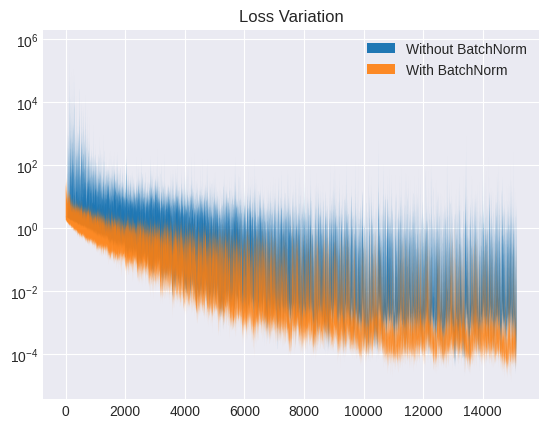

In [32]:
print(len(baseline_loss_landscape_ranges))
baseline_min_vals = [ s[0] for s in baseline_loss_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_loss_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals, alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_loss_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_loss_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals, alpha=0.9, label="With BatchNorm")

plt.yscale("log")
plt.legend()
plt.title("Loss Variation")
plt.show()

# Gradient Variation


In [8]:
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_grad_landscape_ranges, candidate_grad_landscape_ranges = [], []
i = 0

In [ ]:
import time

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit.internal_covariate_shift import grad_landscape_step

%matplotlib inline


try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = (
               step_fn(baseline, baseline_optimizer, batch, labels)
          )
          baseline_copy = baseline.__deepcopy__()
          baseline_copy.eval()
          baseline_grad_range = (
              grad_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_grads,
                                  max_step=4,
                                  step_size=1,
                                  lr=lr
             )
          )
          baseline_grad_landscape_ranges.append(baseline_grad_range)

          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = (
              step_fn(candidate, candidate_optimizer, batch, labels)
          )
          candidate_copy = candidate.__deepcopy__()
          candidate_copy.eval()
          candidate_grad_range = (
            grad_landscape_step(candidate,
                                batch,
                                labels,
                                candidate_grads,
                                max_step=4,
                                step_size=1,
                                lr=lr
             )
          )
          candidate_grad_landscape_ranges.append(candidate_grad_range)

          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)

          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | "
                  f"candidate loss: {candidate_loss:0.4f} | "
                  f"baseline train acc: {baseline_acc:0.2f} | "
                  f"candidate train acc: {candidate_acc:0.2f} | "
                  f"baseline test acc: {baseline_test_acc: 0.2f} | "
                  f"candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9,
                         label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5,
                         label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9,
                         label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5,
                         label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")


15141


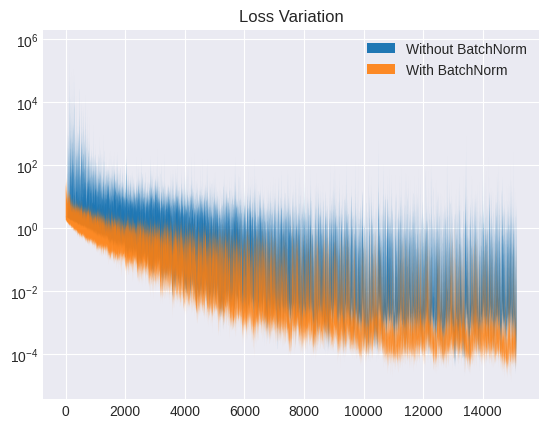

In [ ]:
print(len(baseline_grad_landscape_ranges))
baseline_min_vals = [ s[0] for s in baseline_grad_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_grad_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals, alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_grad_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_grad_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals, alpha=0.9, label="With BatchNorm")

plt.yscale("log")
plt.legend()
plt.title("Gradient Variation")
plt.show()